## Utilities

In [1]:
import re, glob, math
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pathlib import Path
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from data.preprocessing.preprocess import preprocess_plateaus  # preprocessor
from experiments_xy import (
    collect_dataset_from_combined) 
from utils import (
    _expand_combined_files,
    _bin_series,
    nominal_angle_from_path,
    nominal_from_group,
    split_one_plateau_per_angle_test,
    _find_bin_dirs,
    _load_metrics_for_bin,
    _plot_line,
    angle_deg,
    angle_err_deg,
    mag,
    full_plot_suite
)


# Bin & Target Comparison (P3, Rms matrix)

Common bins to evaluate: [102, 512, 1024]
Estimated fs ≈ 10240.00 Hz

=== Building dataset for bin_len=102 (~10.0 ms) ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=102: X_by_mode keys=['rms_matrix'], y=(32356, 3), groups=22
[DONE] processed files: 11/11
MCP angles in TEST: [90.0, 135.0, 180.0]


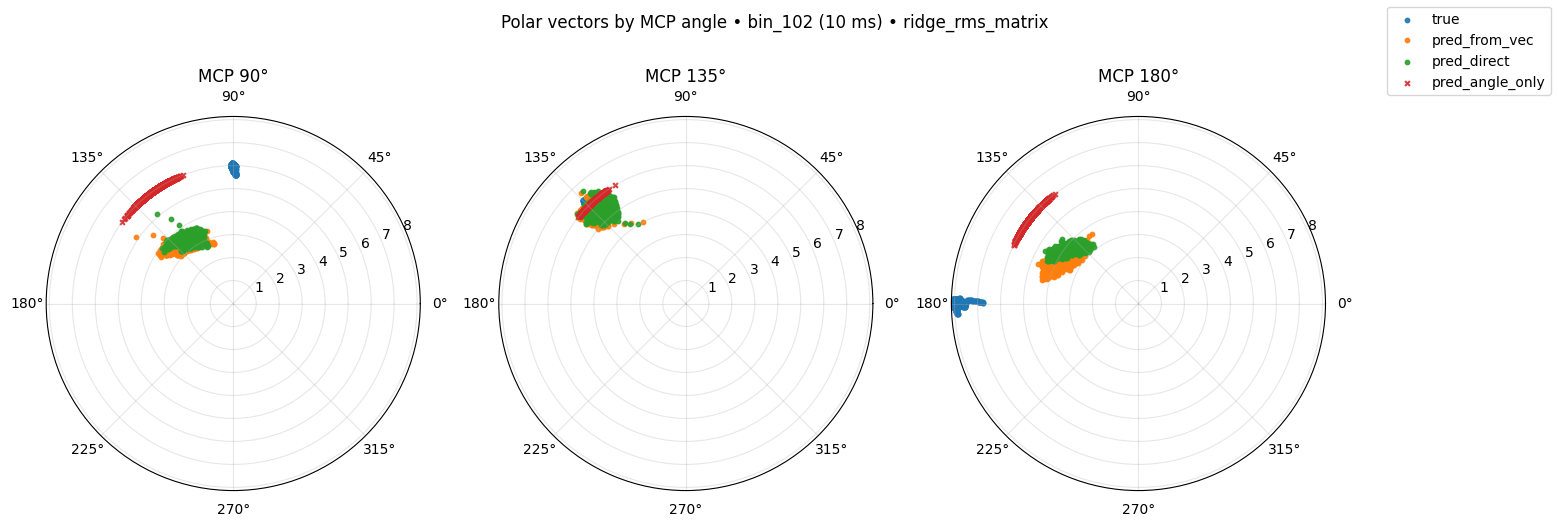


=== Building dataset for bin_len=512 (~50.0 ms) ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=512: X_by_mode keys=['rms_matrix'], y=(6434, 3), groups=22
[DONE] processed files: 11/11
MCP angles in TEST: [90.0, 135.0, 180.0]


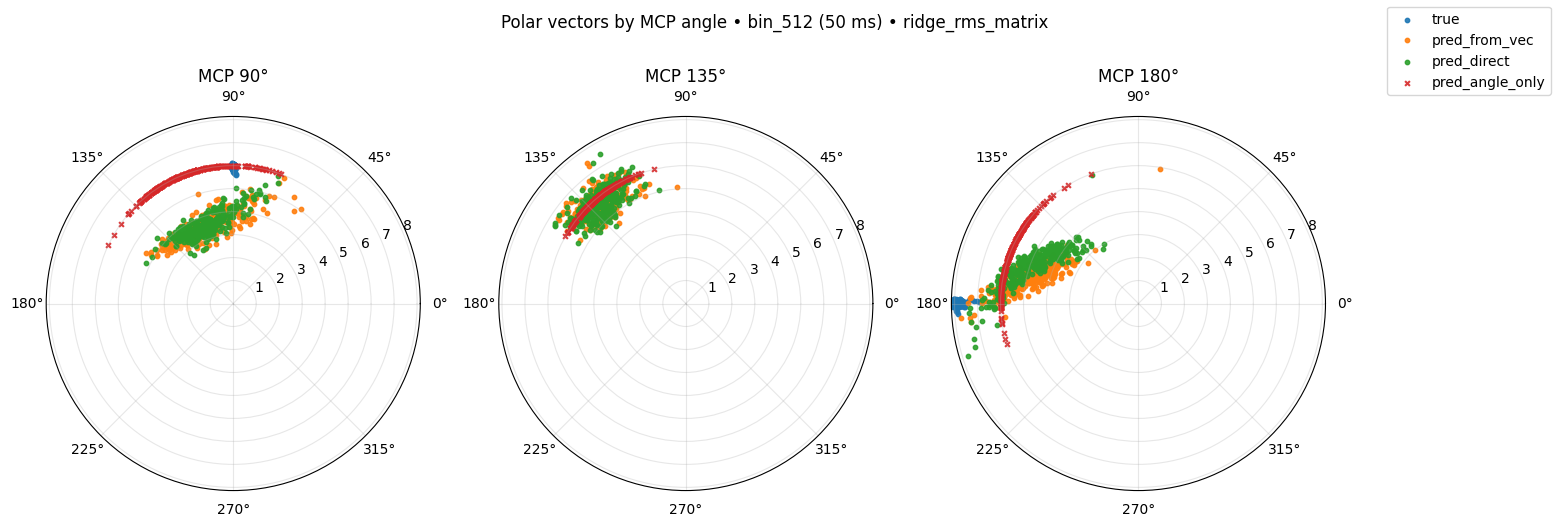


=== Building dataset for bin_len=1024 (~100.0 ms) ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=1024: X_by_mode keys=['rms_matrix'], y=(3211, 3), groups=22
[DONE] processed files: 11/11
MCP angles in TEST: [90.0, 135.0, 180.0]


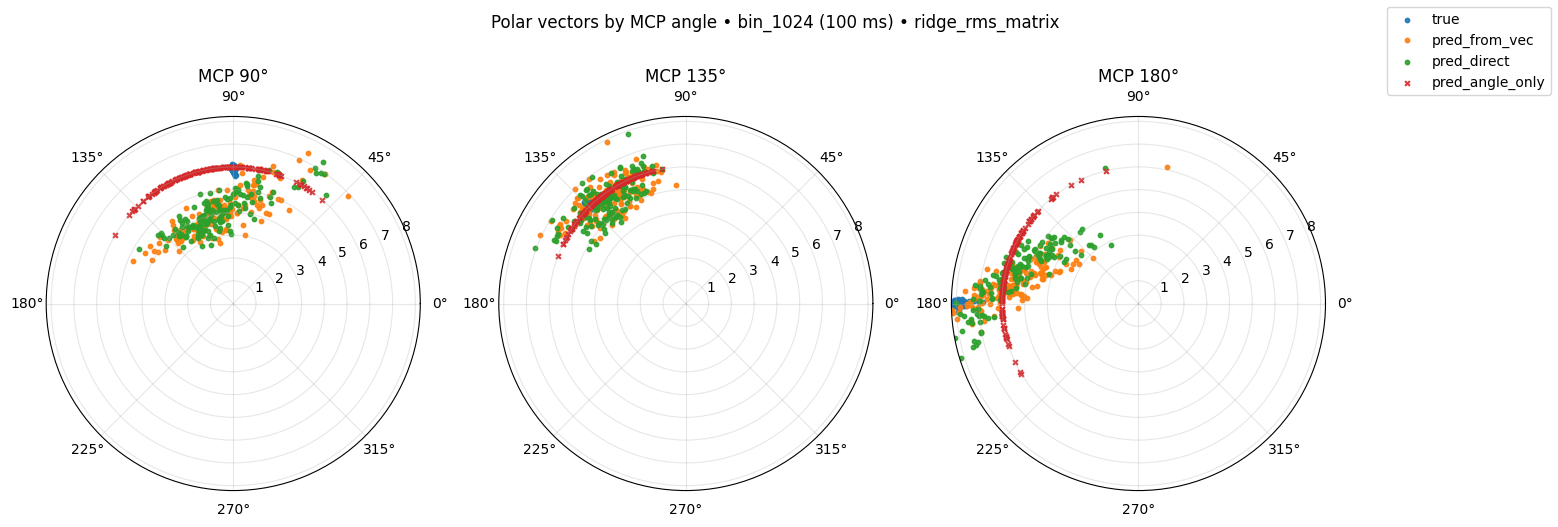

bin_len      bin_ms  MCP_deg     n  mae_single_deg  mae_three_vec_deg  \
0      102    9.960937     90.0  1469       36.248557          41.390934   
1      102    9.960937    135.0  1455        2.950634           1.984659   
2      102    9.960937    180.0  1484       38.340948          28.923917   
3      512   50.000000     90.0   292       22.018395          22.623551   
4      512   50.000000    135.0   289        7.561067           7.184937   
5      512   50.000000    180.0   295       22.007538          14.383882   
6     1024  100.000000     90.0   146       19.103951          19.775903   
7     1024  100.000000    135.0   144       11.777071          12.477381   
8     1024  100.000000    180.0   147       19.717195          12.131765   

   mae_three_direct_deg  
0             36.248557  
1              2.950634  
2             38.340948  
3             22.018395  
4              7.561067  
5             22.007538  
6             19.103951  
7             11.777071  
8             19.717195

In [ ]:
# --- USER CONFIG (edit these to your run folders) ---
from pathlib import Path
COMBINED_DIR = Path("data/preprocessing/P3_combined")         # where *_combined.npy live
RESULTS_ROOT_SINGLE = Path("results_feat/P3_angle_only")      # run trained with y = [Angle]
RESULTS_ROOT_THREE  = Path("results_feat/P3_angle")           # run trained with y = [Fx, Fy, Angle]
RMS_WIN = 100
RANDOM_STATE = 42

MODE = "rms_matrix"            # feature mode to use for both models ("rms_matrix" or "all_channels")
BIN_CHOICE = None              # set a specific bin (e.g., 512/1024) or None to iterate all common bins

# Polar plot options
RADIUS_FOR_ANGLE_ONLY = 6      # fixed radius for angle-only model (red x)
USE_TRUE_FORCE_RADIUS = True   # True: r_true = ||(Fx,Fy)||; False: use filename mapping
USE_PRED_FORCE_RADIUS = True   # True: r_pred_vec = ||(F̂x,F̂y)||; False: constant
USE_FILENAME_FORCE    = False  # If True, map F1/F2 in filenames -> radius via F_LABEL_TO_RADIUS

F_LABEL_TO_RADIUS = {"F1": 1.0, "F2": 2.0}

# === IMPORTS ===
import re, numpy as np, pandas as pd, joblib, math
import matplotlib.pyplot as plt
from pathlib import Path

from experiments_xy import (
    collect_dataset_from_combined,
    split_one_plateau_per_angle_test,   # still used for holdout; grouping for plots comes from buckets
)

# === HELPERS ===
def angle_from_fx_fy(fx, fy):
    ang = np.degrees(np.arctan2(fy, fx))
    return np.where(ang < 0, ang + 360.0, ang)

def circ_diff_deg(a_deg, b_deg):
    return (a_deg - b_deg + 180.0) % 360.0 - 180.0

def circ_mae_deg(a_deg, b_deg):
    return float(np.mean(np.abs(circ_diff_deg(a_deg, b_deg))))

def _load_bin_dir(root: Path):
    bins = sorted([p for p in root.glob("bin_*") if p.is_dir()])
    return {int(p.name.split("_",1)[1]): p for p in bins}

def _load_model_and_scaler(bin_dir: Path, mode=MODE):
    model_path = bin_dir / f"ridge_{mode}.joblib"
    y_scaler_path = bin_dir / "y_scaler.joblib"
    if not model_path.exists():
        raise FileNotFoundError(f"Missing model: {model_path}")
    model = joblib.load(model_path)
    y_scaler = joblib.load(y_scaler_path) if y_scaler_path.exists() else None
    return model, y_scaler

def _force_label_from_path(p: str) -> str | None:
    base = Path(p).stem
    m = re.search(r'_(F\d+)_', base, flags=re.IGNORECASE)
    return m.group(1).upper() if m else None

# ---- Estimate fs once (used to map bin_len -> bin_sec) ----
def _estimate_fs_from_any_file(combined_dir: Path) -> float:
    files = sorted(combined_dir.glob("*_combined.npy"))
    if not files:
        raise FileNotFoundError(f"No *_combined.npy in {combined_dir}")
    payload = np.load(str(files[0]), allow_pickle=True).item()
    t = np.asarray(payload.get("time_s", []), float)
    if t.size >= 2:
        dt = float(np.median(np.diff(t)))
        if dt > 0:
            return 1.0 / dt
    # fallback to meta if present
    meta = payload.get("meta", {}) or {}
    for key in ("fs_force", "fs_emg"):
        v = meta.get(key, None)
        try:
            if v is not None and np.isfinite(float(v)):
                return float(v)
        except Exception:
            pass
    raise RuntimeError("Could not estimate sampling rate (fs)")

# === 0) Discover common bins in your two model roots ===
bins_single = _load_bin_dir(RESULTS_ROOT_SINGLE)
bins_three  = _load_bin_dir(RESULTS_ROOT_THREE)
all_common_bins = sorted(set(bins_single.keys()) & set(bins_three.keys()))
if not all_common_bins:
    raise SystemExit("No common bin_* across the two results roots.")

if BIN_CHOICE is not None:
    common_bins = [b for b in all_common_bins if b == BIN_CHOICE]
    if not common_bins:
        raise SystemExit(f"BIN_CHOICE={BIN_CHOICE} not available in both results roots (have {all_common_bins}).")
else:
    common_bins = all_common_bins

print("Common bins to evaluate:", common_bins)

# === 0.5) Estimate fs once to convert bin_len -> bin_sec for dataset building ===
fs_est = _estimate_fs_from_any_file(COMBINED_DIR)
print(f"Estimated fs ≈ {fs_est:.2f} Hz")

all_summaries = []

# === Iterate through all requested bins ===
for bin_len in common_bins:
    bin_sec = float(bin_len) / fs_est
    print(f"\n=== Building dataset for bin_len={bin_len} (~{bin_sec*1000:.1f} ms) ===")

    # 1) Build dataset for this bin
    buckets = collect_dataset_from_combined(
        str(COMBINED_DIR),
        bin_sec=bin_sec,
        include_angle_target=True,      # keep Fx,Fy,Angle
        rms_win_samples=RMS_WIN,
        modes=(MODE,),                  # collect the feature mode(s) you want available
        segment_kind="plateau",
    )
    if bin_len not in buckets:
        raise SystemExit(f"Collector returned bins {sorted(buckets.keys())}, not the requested {bin_len}.")

    pack = buckets[bin_len]

    # NEW: pull features from X_by_mode
    X_by_mode = pack["X_by_mode"]          # dict: mode -> (N, C_mode)
    if MODE not in X_by_mode:
        raise SystemExit(f"Requested MODE='{MODE}' not present in X_by_mode keys={list(X_by_mode.keys())}")
    X = X_by_mode[MODE]                     # (N, C_mode)
    y = pack["y"]                           # (N, 3) -> Fx, Fy, Angle
    groups = pack["groups"]                 # (N,)
    nominal_angles_all = pack["nominal_angles"]  # (N,) floats (MCP/nominal angle aligned row-wise)


    # 2) Holdout split identical to training logic (still filename-based)
    train_idx, test_idx, test_groups = split_one_plateau_per_angle_test(groups, nominal_angles_all, rng=RANDOM_STATE)
    X_te, y_te, groups_te = X[test_idx], y[test_idx], groups[test_idx]
    # NEW: use nominal angles from bucket (no file I/O)
    mcp_labels = nominal_angles_all[test_idx]   # (N_te,)

    # 3) Ground-truth angles + radius (from Fx,Fy)
    angle_true = angle_from_fx_fy(y_te[:,0], y_te[:,1])
    r_true_mag = np.hypot(y_te[:,0], y_te[:,1])

    if USE_FILENAME_FORCE:
        src_paths = np.array([g.split("::", 1)[0] for g in groups_te])
        f_labels = np.array([_force_label_from_path(p) for p in src_paths])
        r_true = np.array([F_LABEL_TO_RADIUS.get(lbl, np.nan) for lbl in f_labels], float)
    else:
        r_true = r_true_mag if USE_TRUE_FORCE_RADIUS else np.ones_like(r_true_mag)

    # 4) Load models & predict for this bin
    bin_dir_single = bins_single[bin_len]
    bin_dir_three  = bins_three[bin_len]

    model_s, ysc_s = _load_model_and_scaler(bin_dir_single, MODE)  # angle-only run
    model_t, ysc_t = _load_model_and_scaler(bin_dir_three,  MODE)  # 3-target run

    # Feature matrix already matches MODE (no build_X needed)
    X_te_feat = X_te

    pred_s_norm = model_s.predict(X_te_feat)
    pred_t_norm = model_t.predict(X_te_feat)

    pred_s = ysc_s.inverse_transform(pred_s_norm) if ysc_s is not None else pred_s_norm
    pred_t = ysc_t.inverse_transform(pred_t_norm) if ysc_t is not None else pred_t_norm

    # angle-only (N,1)
    angle_pred_single = pred_s.reshape(-1) if pred_s.shape[1] == 1 else pred_s[:, -1]
    r_pred_single = np.full_like(angle_pred_single, RADIUS_FOR_ANGLE_ONLY, dtype=float)

    # 3-target heads
    if pred_t.shape[1] >= 2:
        angle_pred_vec = angle_from_fx_fy(pred_t[:,0], pred_t[:,1])
        r_pred_vec     = np.hypot(pred_t[:,0], pred_t[:,1]) if USE_PRED_FORCE_RADIUS else np.ones(len(pred_t))
    else:
        angle_pred_vec = np.full(len(angle_true), np.nan)
        r_pred_vec     = np.full(len(angle_true), np.nan)

    angle_pred_three_direct = pred_t[:,2] if pred_t.shape[1] >= 3 else np.full(len(angle_true), np.nan)
    angle_pred_three_direct = (angle_pred_three_direct % 360 + 360) % 360
    r_pred_three_direct = r_pred_vec.copy()

    # 5) Group test rows by nominal/MCP angle FROM THE BUCKET
    unique_mcp = np.array(sorted({x for x in mcp_labels if np.isfinite(x)}))
    print("MCP angles in TEST:", unique_mcp.tolist())

    # Determine a sensible rmax across all radii for nice scaling
    all_r = []
    if not USE_FILENAME_FORCE:
        all_r.extend(r_true[~np.isnan(r_true)])
        if np.isfinite(r_pred_vec).any():
            all_r.extend(r_pred_vec[~np.isnan(r_pred_vec)])
    rmax = max(1.0, np.nanpercentile(all_r, 99)) if all_r else 1.0

    cols = min(4, len(unique_mcp)) if len(unique_mcp) else 1
    rows = int(np.ceil(max(1, len(unique_mcp)) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5.2*cols, 5.2*rows),
                             subplot_kw={"projection": "polar"}, squeeze=False)

    summary = []
    for i, mcp in enumerate(unique_mcp):
        ax = axes[i//cols, i%cols]
        idxs = np.where(np.isclose(mcp_labels, mcp, equal_nan=False))[0]

        # convert to radians
        t_true = np.deg2rad(angle_true[idxs]);              r_t  = r_true[idxs]
        t_s    = np.deg2rad(angle_pred_single[idxs]);       r_s  = r_pred_single[idxs]
        t_tv   = np.deg2rad(angle_pred_vec[idxs]);          r_tv = r_pred_vec[idxs]
        t_td   = np.deg2rad(angle_pred_three_direct[idxs]); r_td = r_pred_three_direct[idxs]

        # scatter
        ax.scatter(t_true, r_t, s=10, label="true", alpha=0.9)
        ax.scatter(t_tv,   r_tv, s=10, label="pred_from_vec", alpha=0.9)
        ax.scatter(t_td,   r_td, s=10, label="pred_direct", alpha=0.9)
        ax.scatter(t_s,    r_s, s=12, label="pred_angle_only", alpha=0.9, marker="x")

        ax.set_title(f"MCP {mcp:.0f}°")
        ax.set_rmax(rmax)
        ax.grid(True, alpha=0.3)

        # Circular MAE on angles (r ignored)
        mae_vec   = circ_mae_deg(np.rad2deg(t_tv), np.rad2deg(t_true)) if np.isfinite(t_tv).any() else np.nan
        mae_dir   = circ_mae_deg(np.rad2deg(t_td), np.rad2deg(t_true)) if np.isfinite(t_td).any() else np.nan
        mae_angle = circ_mae_deg(np.rad2deg(t_s),  np.rad2deg(t_true))
        summary.append({
            "bin_len": int(bin_len),
            "bin_ms": bin_sec*1000.0,
            "MCP_deg": float(mcp),
            "n": int(len(idxs)),
            "mae_single_deg": mae_angle,
            "mae_three_vec_deg": mae_vec,
            "mae_three_direct_deg": mae_dir
        })

    # Shared legend
    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right")
    fig.suptitle(f"Polar vectors by MCP angle • bin_{bin_len} ({bin_sec*1000:.0f} ms) • ridge_{MODE}", y=0.98)
    fig.tight_layout(rect=[0,0,0.88,0.95])
    plt.show()

    all_summaries.append(pd.DataFrame(summary).sort_values(["bin_len", "MCP_deg"]))

# Final combined summary (one row per MCP per bin)
summary_df = pd.concat(all_summaries, ignore_index=True) if all_summaries else pd.DataFrame()
summary_df


In [3]:
if summary_df.empty:
    raise SystemExit("summary_df is empty – no results to summarize.")

# --- 1️⃣ Overall mean performance across all bins & MCP angles ---
overall_mean = summary_df[["mae_single_deg","mae_three_vec_deg","mae_three_direct_deg"]].mean().to_frame("MAE_deg_mean")
print("\n=== Overall Mean MAE (°) Across All Bins & MCP Angles ===")
print(overall_mean)

best_overall = overall_mean["MAE_deg_mean"].idxmin()
print(f"\nBest model overall: {best_overall} with {overall_mean.loc[best_overall, 'MAE_deg_mean']:.2f}°")

# --- 2️⃣ Mean per bin_len (across all MCPs) ---
mean_per_bin = (
    summary_df
    .groupby("bin_len")[["mae_single_deg","mae_three_vec_deg","mae_three_direct_deg"]]
    .mean()
    .sort_index()
)
print("\n=== Mean MAE (°) per bin_len ===")
print(mean_per_bin.round(2))

# Which model wins per bin?
winner_per_bin = mean_per_bin.idxmin(axis=1).rename("best_model")
print("\nBest model per bin:")
print(winner_per_bin)

# --- 3️⃣ Mean per MCP angle (across all bins) ---
mean_per_mcp = (
    summary_df
    .groupby("MCP_deg")[["mae_single_deg","mae_three_vec_deg","mae_three_direct_deg"]]
    .mean()
    .sort_index()
)
print("\n=== Mean MAE (°) per MCP angle ===")
print(mean_per_mcp.round(2))

winner_per_mcp = mean_per_mcp.idxmin(axis=1).rename("best_model")
print("\nBest model per MCP angle:")
print(winner_per_mcp)




=== Overall Mean MAE (°) Across All Bins & MCP Angles ===
                      MAE_deg_mean
mae_single_deg           22.287202
mae_three_vec_deg        20.597256
mae_three_direct_deg     22.287202

Best model overall: mae_three_vec_deg with 20.60°

=== Mean MAE (°) per bin_len ===
         mae_single_deg  mae_three_vec_deg  mae_three_direct_deg
bin_len                                                         
102               27.99              26.79                 27.99
512               20.93              18.96                 20.93
1024              17.95              16.04                 17.95

Best model per bin:
bin_len
102     mae_three_vec_deg
512     mae_three_vec_deg
1024    mae_three_vec_deg
Name: best_model, dtype: object

=== Mean MAE (°) per MCP angle ===
         mae_single_deg  mae_three_vec_deg  mae_three_direct_deg
MCP_deg                                                         
90.0              29.97              32.44                 29.97
135.0              8.

# Feature vs. Target Comparison (P3, Bin 50ms) 

Common bins: [102, 512, 1024]
Evaluating all MODES at fixed bin_len=512 (~50.0 ms)

=== Evaluating MODE: iterative_addition ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=512: X_by_mode keys=['iterative_addition'], y=(6434, 3), groups=22
[DONE] processed files: 11/11
[iterative] found 16 steps; example shape at k=1: (6434, 1)
[iterative] k=1: X_te.shape=(876, 1), model_s.n_features_in_=1, model_t.n_features_in_=1
MCP angles in TEST: [90.0, 135.0, 180.0]


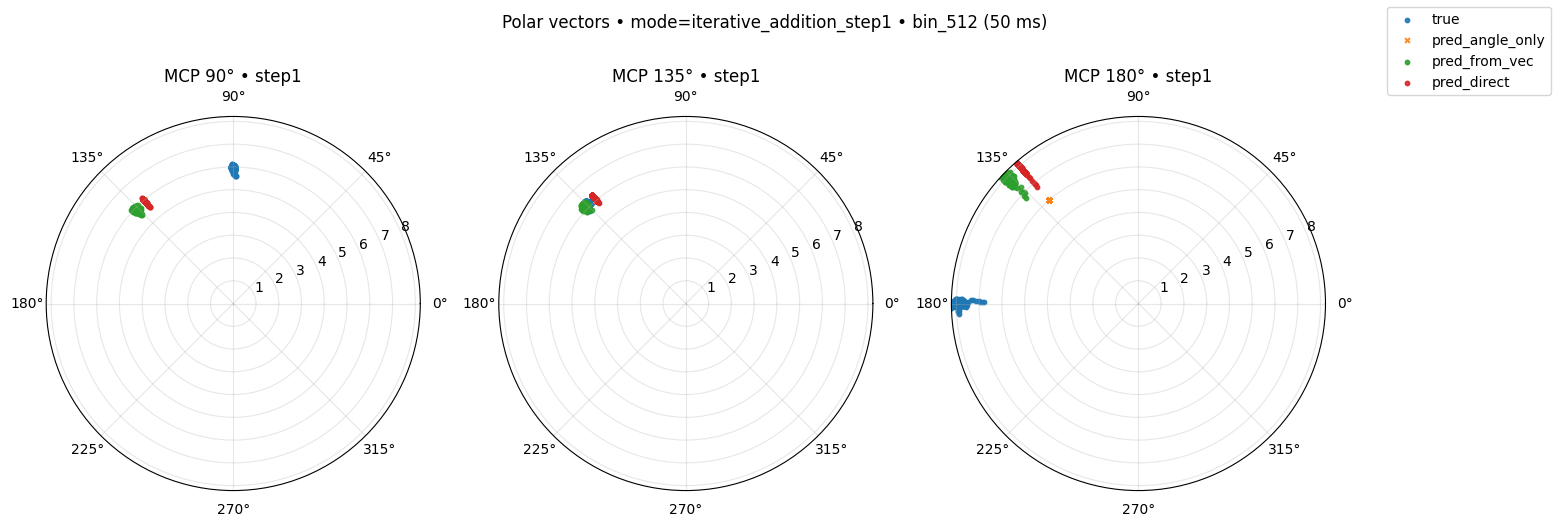

[iterative] k=2: X_te.shape=(876, 2), model_s.n_features_in_=2, model_t.n_features_in_=2
MCP angles in TEST: [90.0, 135.0, 180.0]


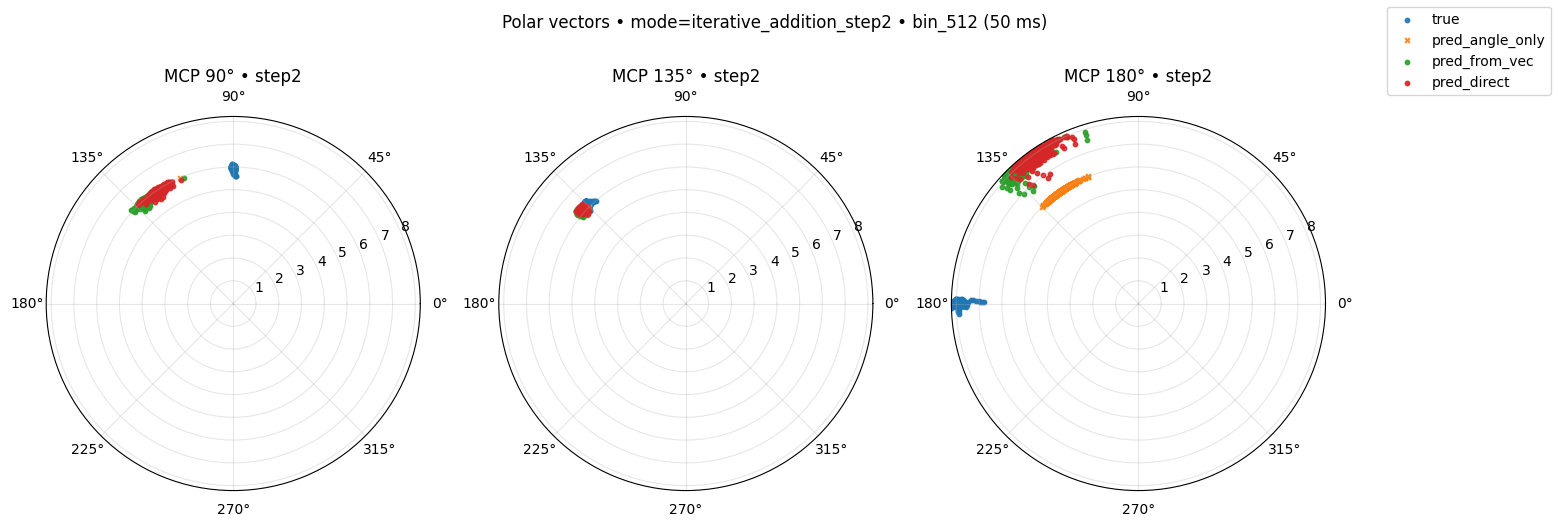

[iterative] k=3: X_te.shape=(876, 3), model_s.n_features_in_=3, model_t.n_features_in_=3
MCP angles in TEST: [90.0, 135.0, 180.0]


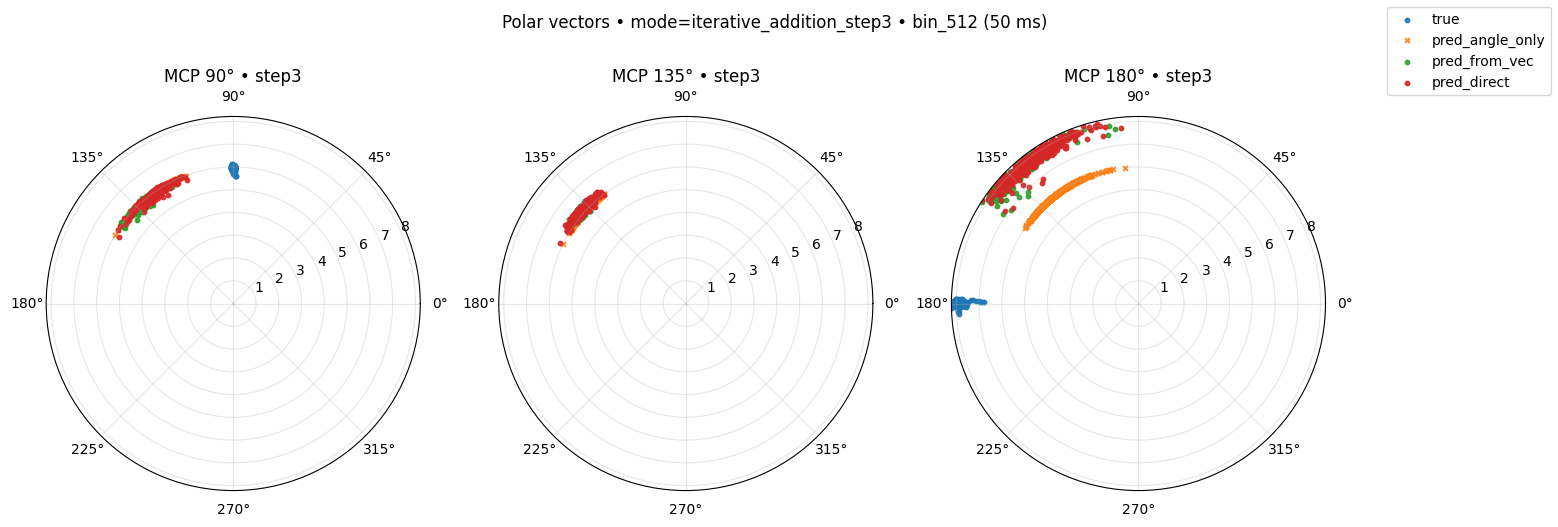

[iterative] k=4: X_te.shape=(876, 4), model_s.n_features_in_=4, model_t.n_features_in_=4
MCP angles in TEST: [90.0, 135.0, 180.0]


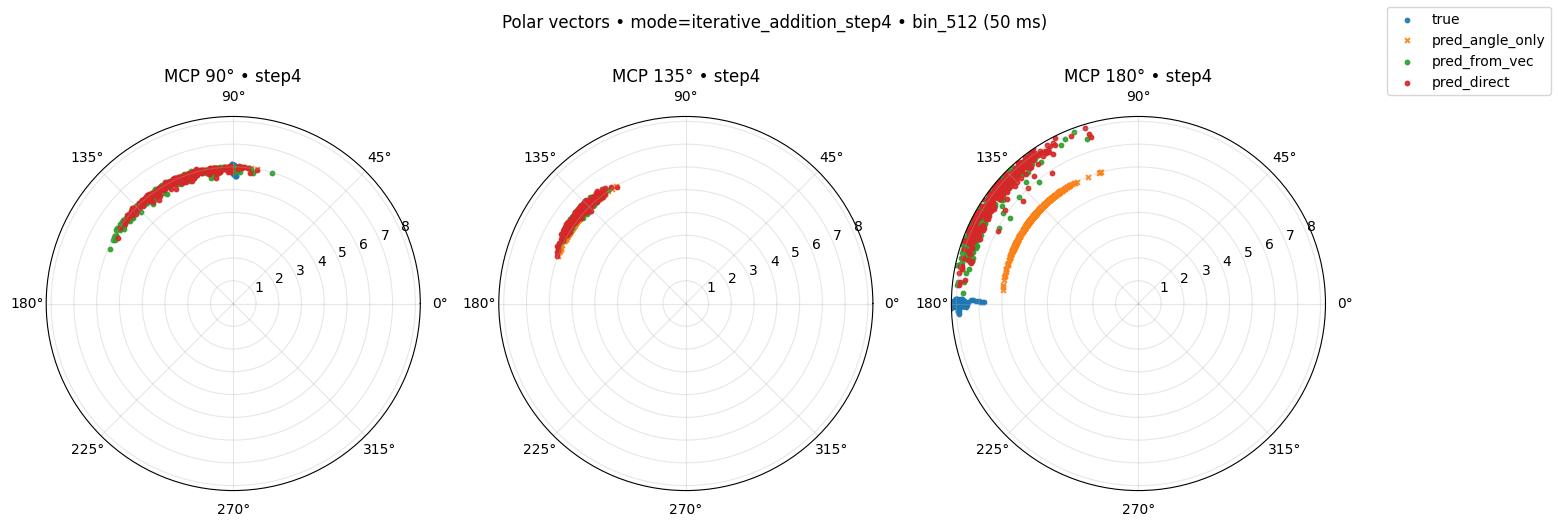

[iterative] k=5: X_te.shape=(876, 5), model_s.n_features_in_=5, model_t.n_features_in_=5
MCP angles in TEST: [90.0, 135.0, 180.0]


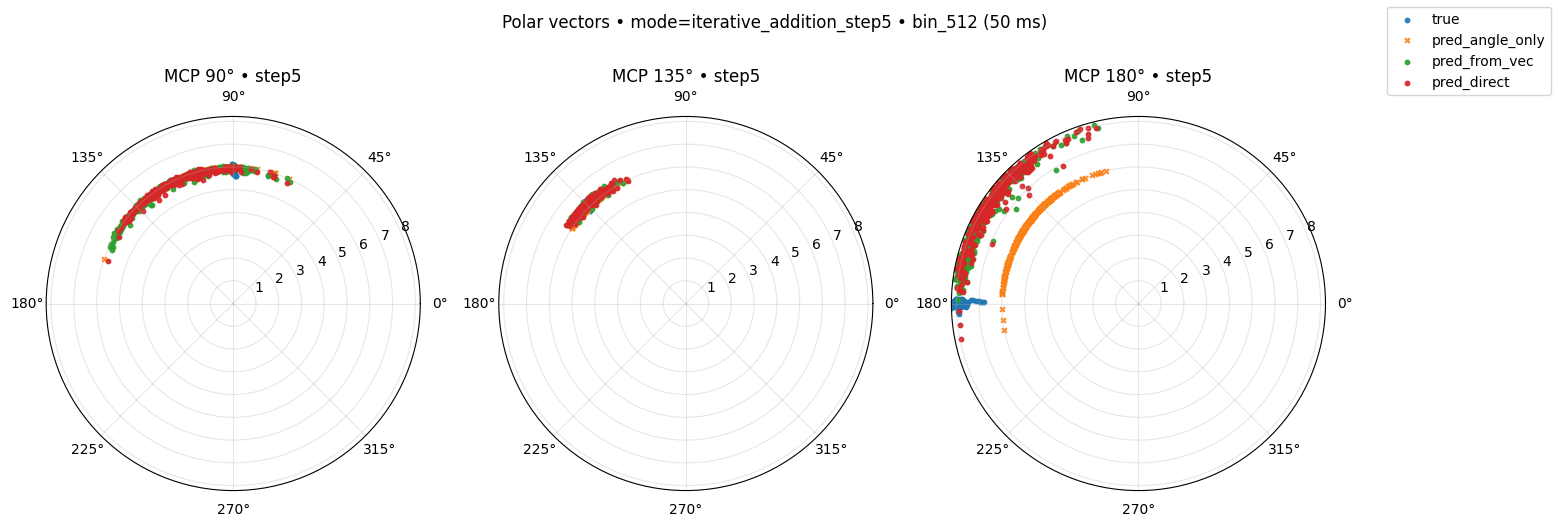

[iterative] k=6: X_te.shape=(876, 6), model_s.n_features_in_=6, model_t.n_features_in_=6
MCP angles in TEST: [90.0, 135.0, 180.0]


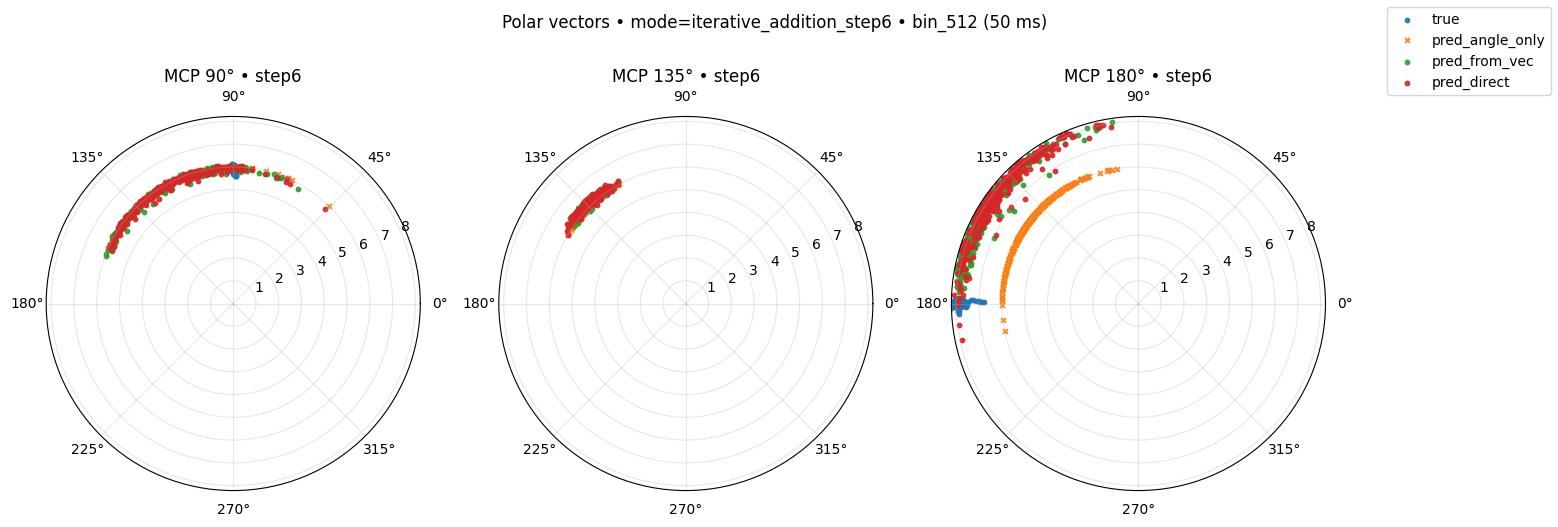

[iterative] k=7: X_te.shape=(876, 7), model_s.n_features_in_=7, model_t.n_features_in_=7
MCP angles in TEST: [90.0, 135.0, 180.0]


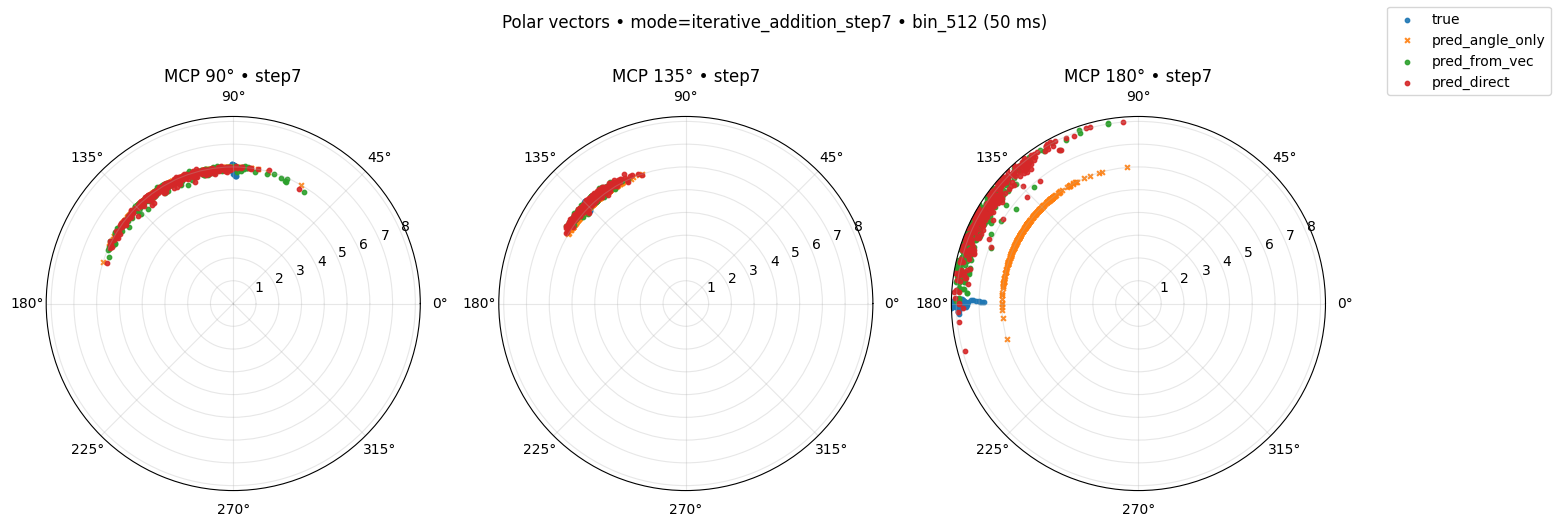

[iterative] k=8: X_te.shape=(876, 8), model_s.n_features_in_=8, model_t.n_features_in_=8
MCP angles in TEST: [90.0, 135.0, 180.0]


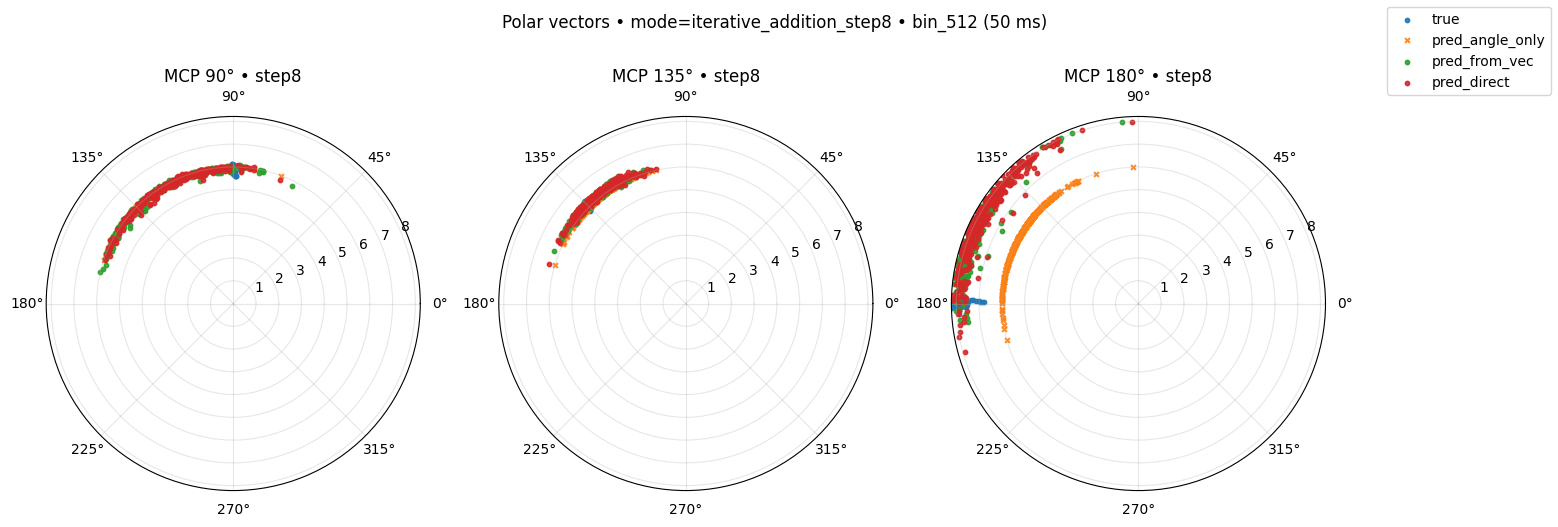

[iterative] k=9: X_te.shape=(876, 9), model_s.n_features_in_=9, model_t.n_features_in_=9
MCP angles in TEST: [90.0, 135.0, 180.0]


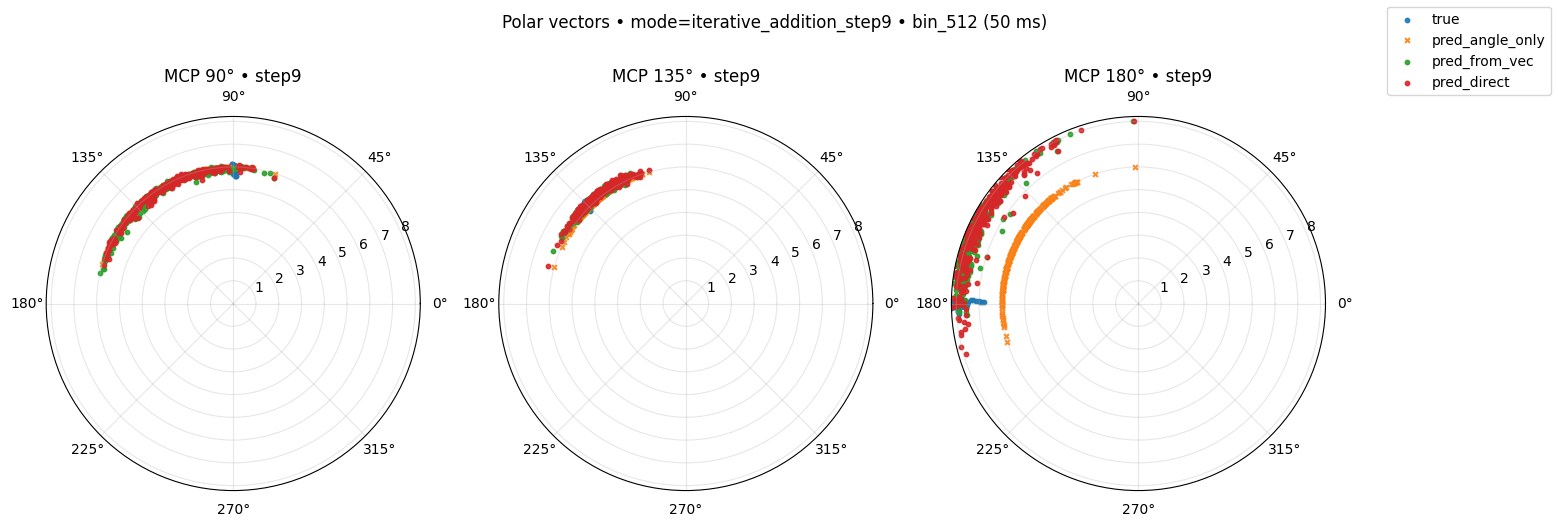

[iterative] k=10: X_te.shape=(876, 10), model_s.n_features_in_=10, model_t.n_features_in_=10
MCP angles in TEST: [90.0, 135.0, 180.0]


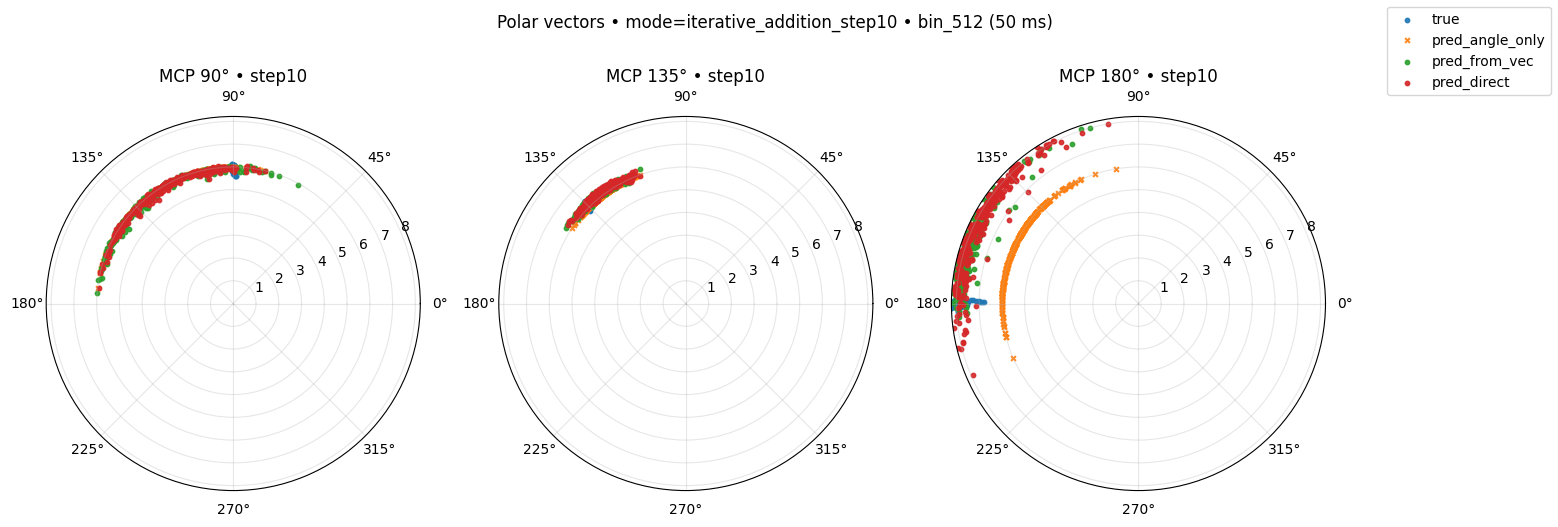

[iterative] k=11: X_te.shape=(876, 11), model_s.n_features_in_=11, model_t.n_features_in_=11
MCP angles in TEST: [90.0, 135.0, 180.0]


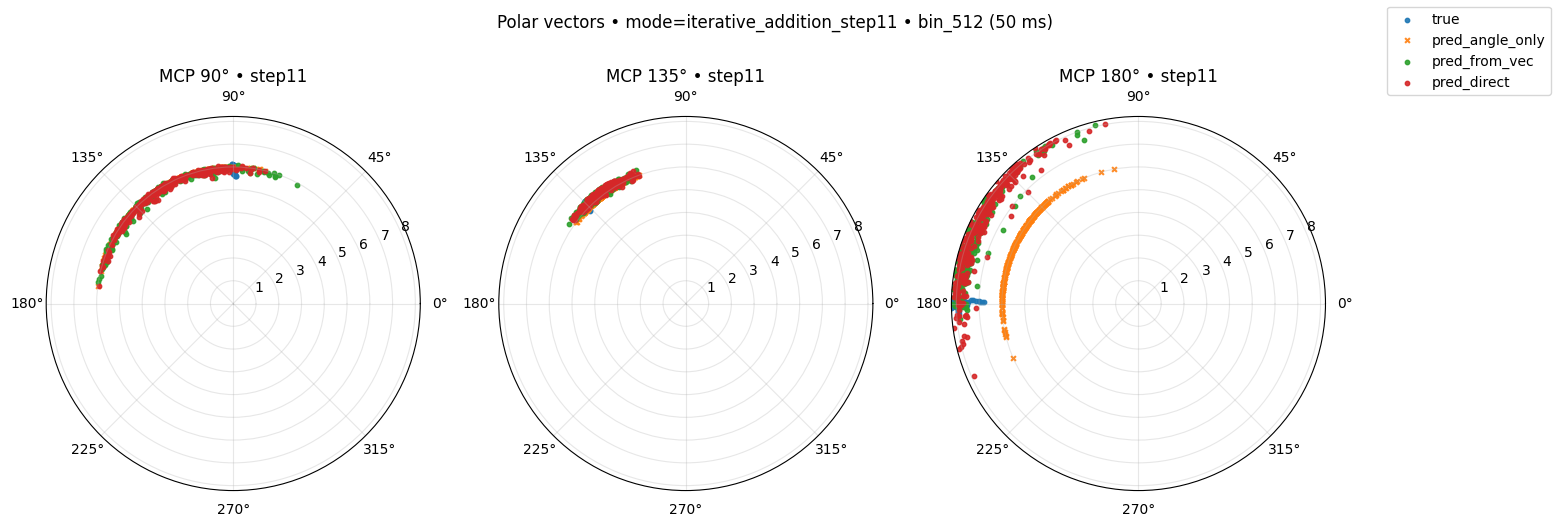

[iterative] k=12: X_te.shape=(876, 12), model_s.n_features_in_=12, model_t.n_features_in_=12
MCP angles in TEST: [90.0, 135.0, 180.0]


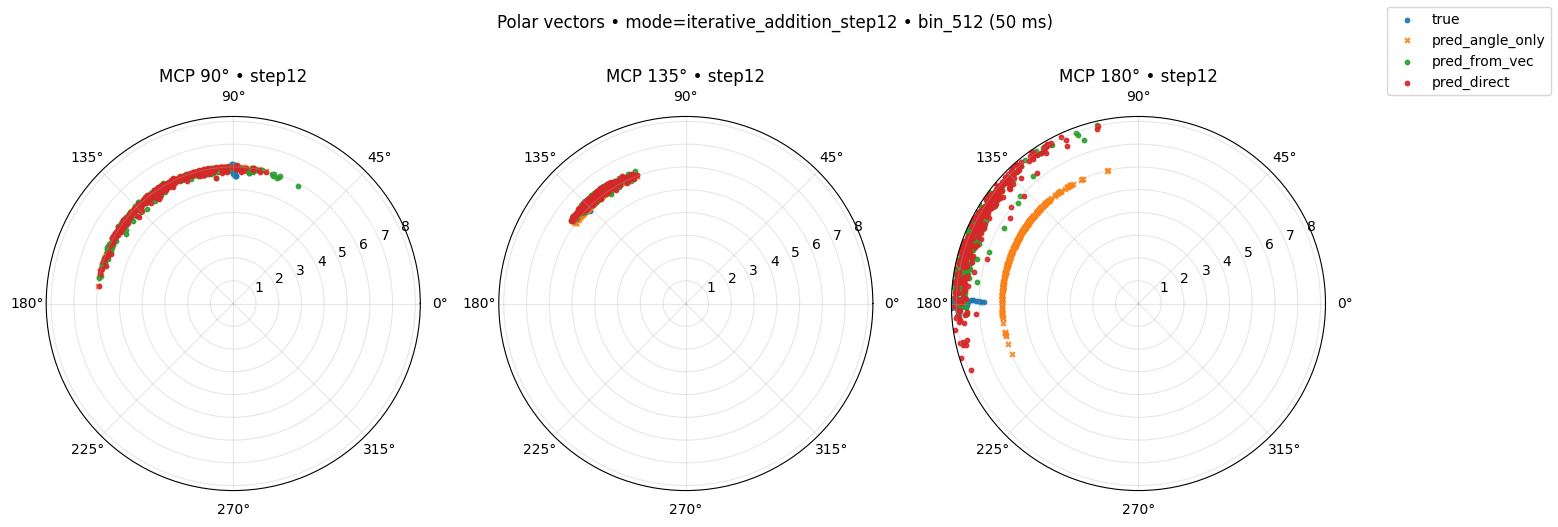

[iterative] k=13: X_te.shape=(876, 13), model_s.n_features_in_=13, model_t.n_features_in_=13
MCP angles in TEST: [90.0, 135.0, 180.0]


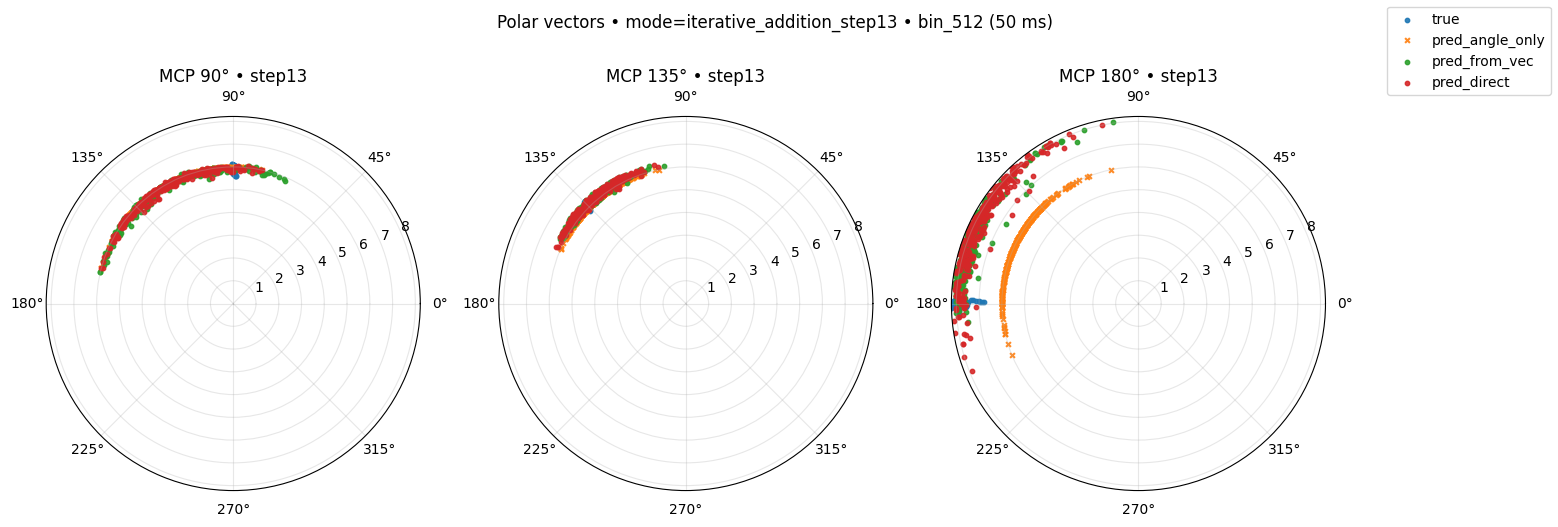

[iterative] k=14: X_te.shape=(876, 14), model_s.n_features_in_=14, model_t.n_features_in_=14
MCP angles in TEST: [90.0, 135.0, 180.0]


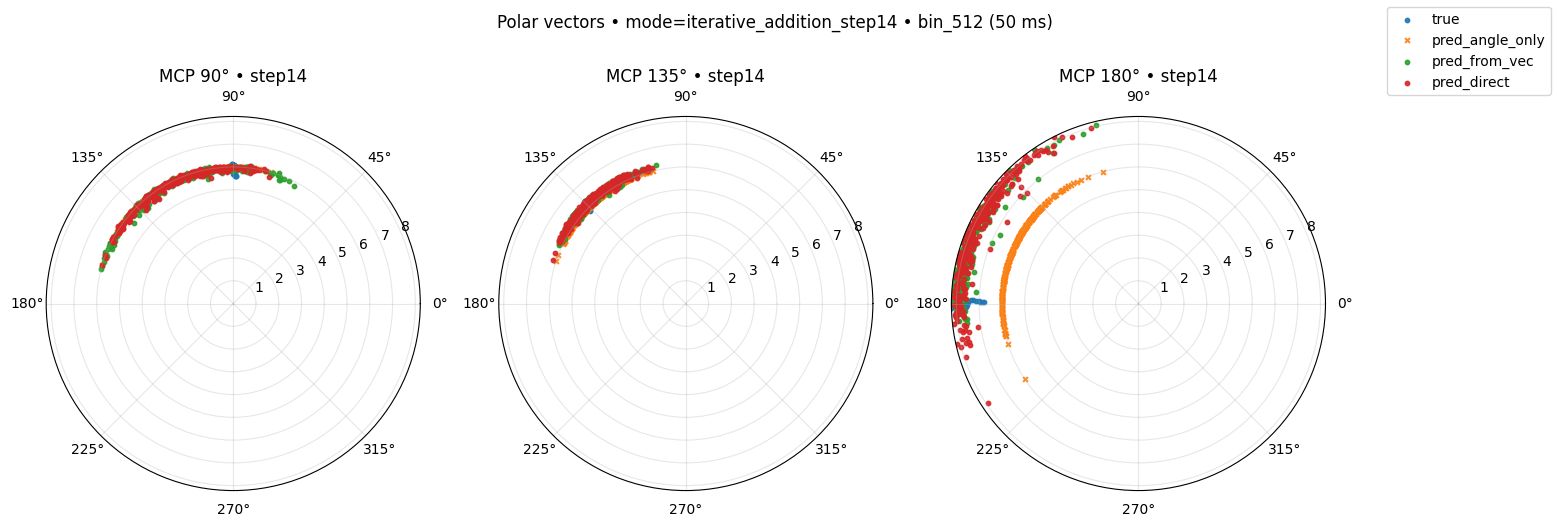

[iterative] k=15: X_te.shape=(876, 15), model_s.n_features_in_=15, model_t.n_features_in_=15
MCP angles in TEST: [90.0, 135.0, 180.0]


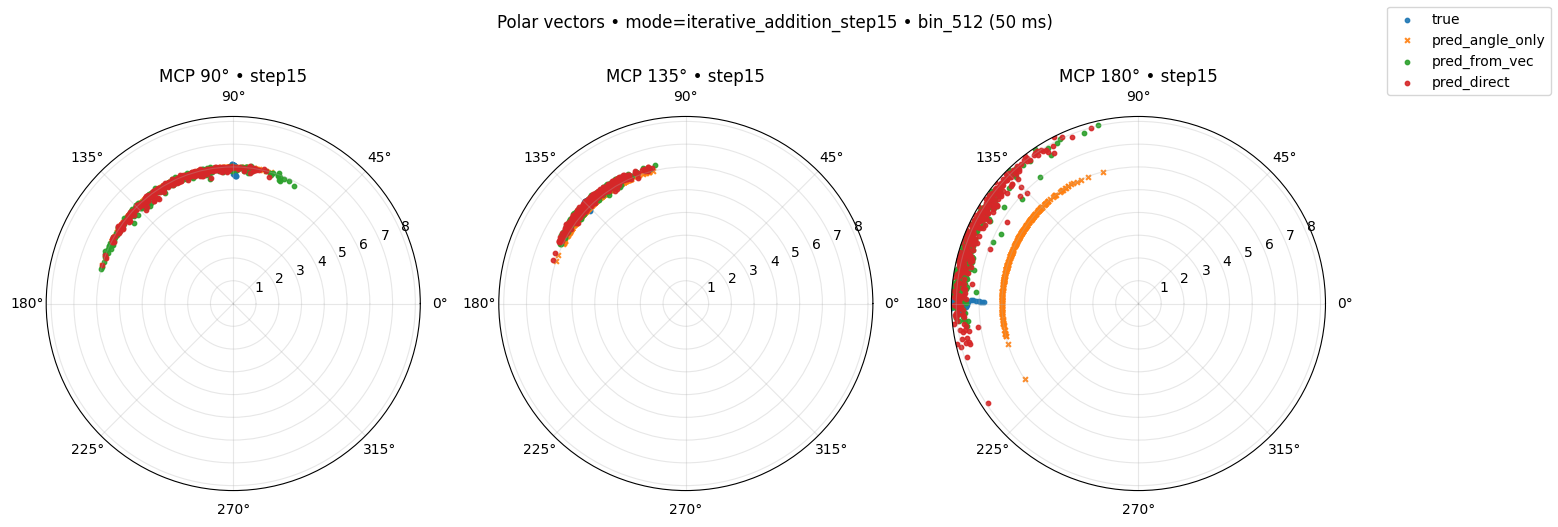

[iterative] k=16: X_te.shape=(876, 16), model_s.n_features_in_=16, model_t.n_features_in_=16
MCP angles in TEST: [90.0, 135.0, 180.0]


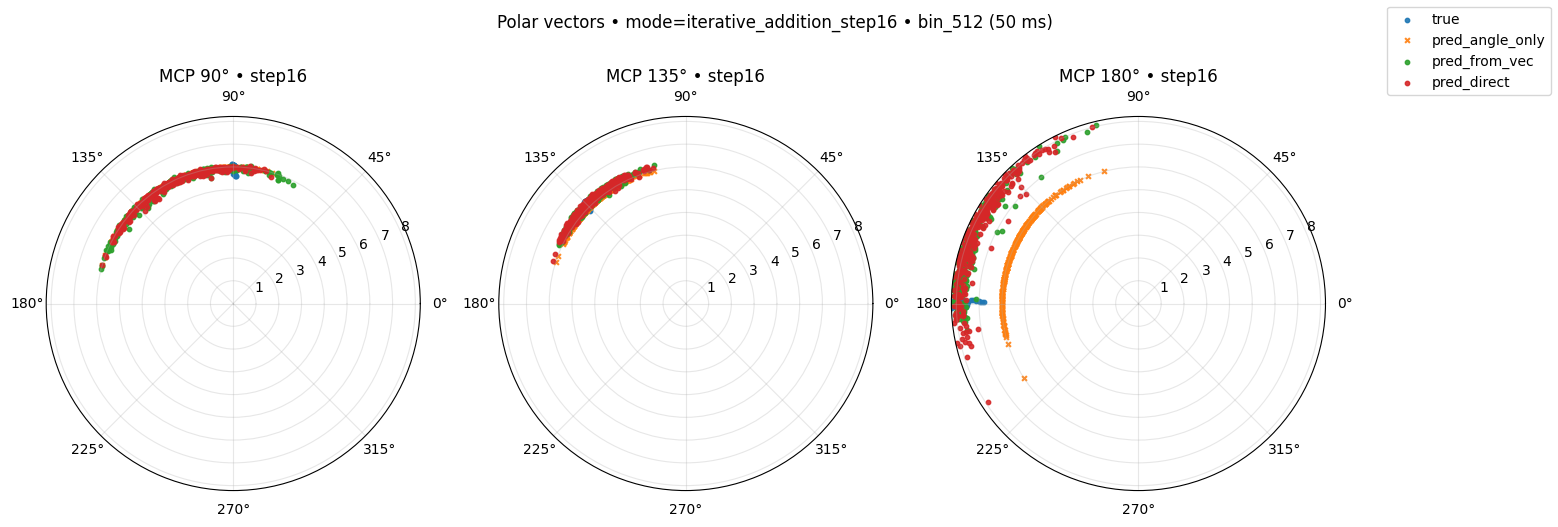


=== Evaluating MODE: rms_matrix ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=512: X_by_mode keys=['rms_matrix'], y=(6434, 3), groups=22
[DONE] processed files: 11/11
MCP angles in TEST: [90.0, 135.0, 180.0]


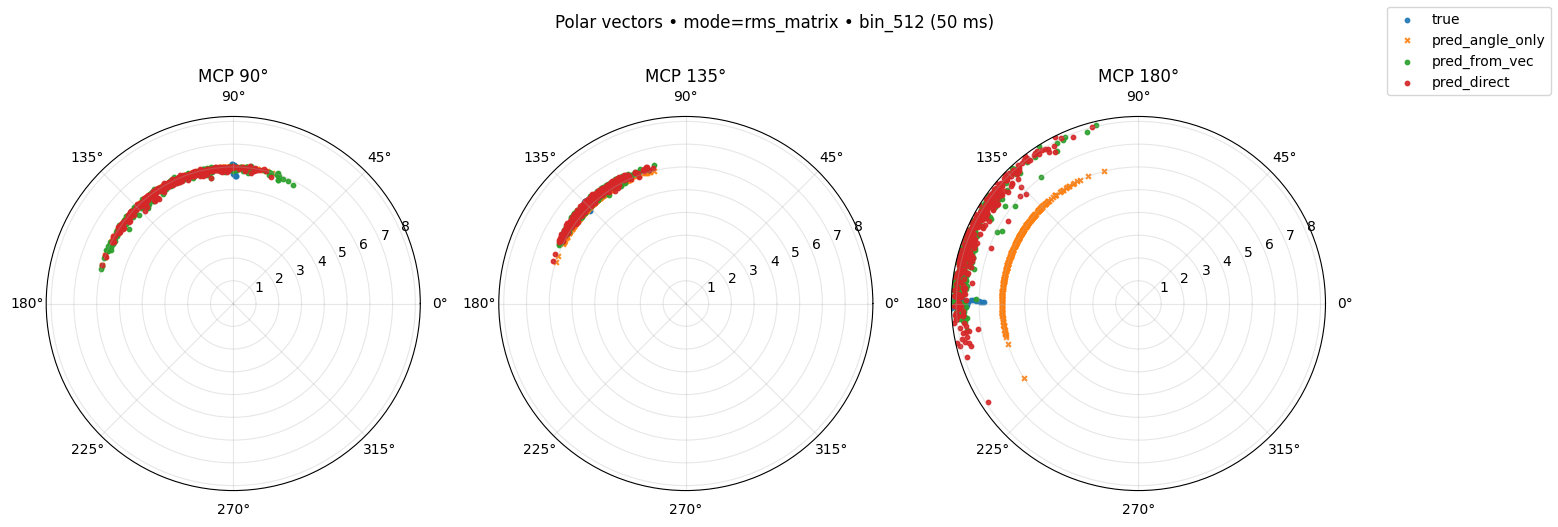


=== Evaluating MODE: all_channels ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=512: X_by_mode keys=['all_channels'], y=(6434, 3), groups=22
[DONE] processed files: 11/11
MCP angles in TEST: [90.0, 135.0, 180.0]


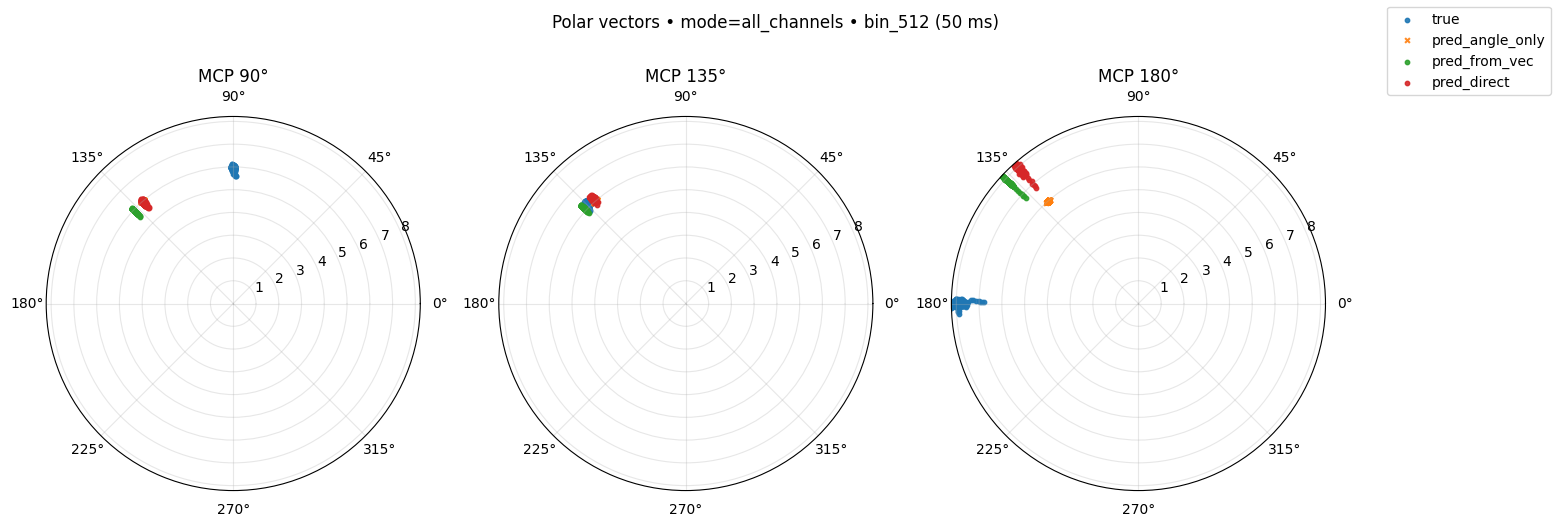


=== Evaluating MODE: average_channels ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=512: X_by_mode keys=['average_channels'], y=(6434, 3), groups=22
[DONE] processed files: 11/11
MCP angles in TEST: [90.0, 135.0, 180.0]


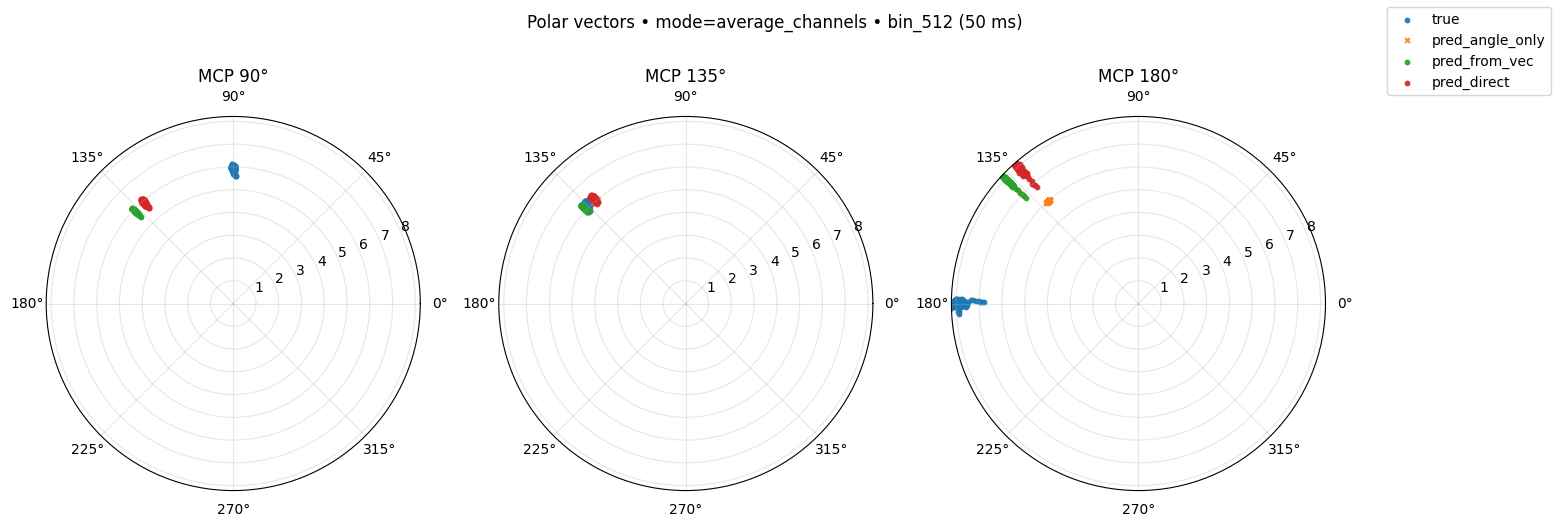

In [22]:
# --- USER CONFIG (edit these to your run folders) ---
from pathlib import Path
COMBINED_DIR = Path("data/preprocessing/P3_combined")         # where *_combined.npy live
RESULTS_ROOT_SINGLE = Path("results_feat/P3_angle_only")      # run trained with y = [Angle]
RESULTS_ROOT_THREE  = Path("results_feat/P3_angle")           # run trained with y = [Fx, Fy, Angle]
RMS_WIN = 100
RANDOM_STATE = 42

# evaluate multiple feature modes instead of bin_len
MODES_TO_EVAL = ["iterative_addition", "rms_matrix", "all_channels", "average_channels",]  

BIN_CHOICE = 512  # pick one bin to hold constant (or set None to use the first common)

# Polar plot options
RADIUS_FOR_ANGLE_ONLY = 6
USE_TRUE_FORCE_RADIUS = True
USE_PRED_FORCE_RADIUS = True
USE_FILENAME_FORCE    = False
F_LABEL_TO_RADIUS = {"F1": 1.0, "F2": 2.0}

# === Discover bin directories once ===
bins_single = _load_bin_dir(RESULTS_ROOT_SINGLE)
bins_three  = _load_bin_dir(RESULTS_ROOT_THREE)
common_bins = sorted(set(bins_single.keys()) & set(bins_three.keys()))
if not common_bins:
    raise SystemExit("No common bin_* across the two results roots.")
print("Common bins:", common_bins)

# choose one bin_len for this analysis (use BIN_CHOICE or first available)
if BIN_CHOICE is None:
    bin_len = common_bins[0]
else:
    if BIN_CHOICE not in common_bins:
        raise SystemExit(f"BIN_CHOICE={BIN_CHOICE} not found. Available: {common_bins}")
    bin_len = BIN_CHOICE

# estimate fs → convert bin_len to seconds
fs_est = _estimate_fs_from_any_file(COMBINED_DIR)
bin_sec = float(bin_len) / fs_est
print(f"Evaluating all MODES at fixed bin_len={bin_len} (~{bin_sec*1000:.1f} ms)")

# ==============================================================
# === Helpers for MODE evaluation (esp. iterative_addition) ===
# ==============================================================

import re, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

def _compute_truth_from_y(y_subset, groups_subset, use_filename_force, use_true_radius):
    angle_true = angle_from_fx_fy(y_subset[:,0], y_subset[:,1])
    r_true_mag = np.hypot(y_subset[:,0], y_subset[:,1])
    if use_filename_force:
        src_paths = np.array([g.split("::", 1)[0] for g in groups_subset])
        f_labels = np.array([_force_label_from_path(p) for p in src_paths])
        r_true = np.array([F_LABEL_TO_RADIUS.get(lbl, np.nan) for lbl in f_labels], float)
    else:
        r_true = r_true_mag if use_true_radius else np.ones_like(r_true_mag)
    return angle_true, r_true

def _extract_iterative_X_cumulative(X_by_mode):
    """
    Normalize iterative_addition features to a dict {k: X_k_cum} where each value is (N, k).

    Supports:
      A) X_by_mode['iterative_addition'] = [X1, X2, ..., XK]
         - If entries are (N,1), build cumulative by hstack([X1,...,Xk]) -> (N,k)
         - If entries are already (N,k) cumulative at step k, use as-is.
      B) X_by_mode has keys like 'iterative_add_k1', 'iterative_add_k2', ... each (N,k).
    """
    out = {}

    # Pattern B: separate keys per step
    step_items = []
    for key in list(X_by_mode.keys()):
        m = re.match(r"iterative_add_k(\d+)$", str(key))
        if m:
            k = int(m.group(1))
            Xk = np.asarray(X_by_mode[key])
            if Xk.ndim == 1:
                Xk = Xk.reshape(-1, 1)
            # Expect cumulative at k: (N,k)
            if Xk.ndim != 2 or Xk.shape[1] != k:
                raise ValueError(f"{key}: expected shape (N,{k}), got {Xk.shape}")
            step_items.append((k, Xk))

    if step_items:
        # Already cumulative per key
        for k, Xk in sorted(step_items, key=lambda t: t[0]):
            out[k] = Xk
        return out

    # Pattern A: single list under 'iterative_addition'
    if "iterative_addition" in X_by_mode:
        lst = X_by_mode["iterative_addition"]
        if not isinstance(lst, (list, tuple)) or len(lst) == 0:
            raise ValueError("X_by_mode['iterative_addition'] must be a non-empty list")

        # Decide whether entries are (N,1) unit steps or already cumulative (N,k)
        # We'll build cumulative either way to guarantee (N,k).
        mats = []
        N_ref = None
        for i, Xi in enumerate(lst, start=1):
            Xi = np.asarray(Xi)
            if Xi.ndim == 1:
                Xi = Xi.reshape(-1, 1)
            if Xi.ndim != 2:
                raise ValueError(f"iterative_addition entry {i}: expected 2D, got {Xi.shape}")
            if N_ref is None:
                N_ref = Xi.shape[0]
            elif Xi.shape[0] != N_ref:
                raise ValueError(f"iterative_addition entry {i}: row mismatch {Xi.shape[0]} vs {N_ref}")
            mats.append(Xi)

        # If entries look like (N,i) already cumulative, just validate and assign.
        # Otherwise, if entries are (N,1), build cumulative by hstack.
        cumulative_detected = all(mats[i-1].shape[1] == i for i in range(1, len(mats)+1))
        if cumulative_detected:
            for k, Xk in enumerate(mats, start=1):
                out[k] = Xk  # already (N,k)
        else:
            # assume unit steps: build cumulative (N,k) by stacking first k columns
            cols_one = all(M.shape[1] == 1 for M in mats)
            if not cols_one:
                raise ValueError("iterative_addition list is neither (N,1) steps nor (N,k) cumulative per index.")
            for k in range(1, len(mats)+1):
                out[k] = np.hstack(mats[:k])  # (N,k)

        return out

    raise KeyError("No iterative_addition features found in X_by_mode.")


def _polar_block(mode_label, bin_len, bin_sec, mcp_labels, angle_true, r_true,
                 angle_pred_single, angle_pred_vec=None, angle_pred_three_direct=None,
                 subtitle_suffix=""):
    """Plot per-MCP polar scatter + return summary rows."""
    unique_mcp = np.array(sorted({x for x in mcp_labels if np.isfinite(x)}))
    print("MCP angles in TEST:", unique_mcp.tolist())

    # rmax from truths (clean & stable scaling)
    all_r = r_true[~np.isnan(r_true)]
    rmax = max(1.0, np.nanpercentile(all_r, 99)) if all_r.size else 1.0

    cols = min(4, len(unique_mcp)) if len(unique_mcp) else 1
    rows = int(np.ceil(max(1, len(unique_mcp)) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5.2*cols, 5.2*rows),
                             subplot_kw={"projection": "polar"}, squeeze=False)

    summary_rows = []
    for i, mcp in enumerate(unique_mcp):
        ax = axes[i//cols, i%cols]
        idxs = np.where(np.isclose(mcp_labels, mcp, equal_nan=False))[0]

        t_true = np.deg2rad(angle_true[idxs]);  r_t  = r_true[idxs]
        t_s    = np.deg2rad(angle_pred_single[idxs]);  r_s = np.full_like(t_s, RADIUS_FOR_ANGLE_ONLY)

        ax.scatter(t_true, r_t, s=10, label="true", alpha=0.9)
        ax.scatter(t_s,    r_s, s=12, label="pred_angle_only", alpha=0.9, marker="x")

        mae_angle = circ_mae_deg(np.rad2deg(t_s), np.rad2deg(t_true))

        mae_vec = np.nan
        if angle_pred_vec is not None:
            t_tv = np.deg2rad(angle_pred_vec[idxs])
            ax.scatter(t_tv, r_t, s=10, label="pred_from_vec", alpha=0.9)
            mae_vec = circ_mae_deg(np.rad2deg(t_tv), np.rad2deg(t_true))

        mae_dir = np.nan
        if angle_pred_three_direct is not None:
            t_td = np.deg2rad(angle_pred_three_direct[idxs])
            ax.scatter(t_td, r_t, s=10, label="pred_direct", alpha=0.9)
            mae_dir = circ_mae_deg(np.rad2deg(t_td), np.rad2deg(t_true))

        ax.set_title(f"MCP {mcp:.0f}°{subtitle_suffix}")
        ax.set_rmax(rmax)
        ax.grid(True, alpha=0.3)

        summary_rows.append({
            "mode": mode_label,
            "bin_len": int(bin_len),
            "bin_ms": float(bin_sec*1000.0),
            "MCP_deg": float(mcp),
            "n": int(len(idxs)),
            "mae_single_deg": float(mae_angle),
            "mae_three_vec_deg": float(mae_vec) if np.isfinite(mae_vec) else np.nan,
            "mae_three_direct_deg": float(mae_dir) if np.isfinite(mae_dir) else np.nan,
        })

    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right")
    fig.suptitle(f"Polar vectors • mode={mode_label} • bin_{bin_len} ({bin_sec*1000:.0f} ms)", y=0.98)
    fig.tight_layout(rect=[0,0,0.88,0.95])
    plt.show()
    return summary_rows

# ==============================================================
# === ITERATE THROUGH FEATURE MODES (with iterative_addition) ==
# ==============================================================

all_summaries = []

for MODE in MODES_TO_EVAL:
    print(f"\n=== Evaluating MODE: {MODE} ===")

    # tell the collector how to cumulate channels for iterative mode
    if MODE == "iterative_addition":
        iterative_channels = list(range(16))  # adjust if your EMG channel count differs
    else:
        iterative_channels = None

    # 1) Build dataset for this mode at fixed bin size
    buckets = collect_dataset_from_combined(
        str(COMBINED_DIR),
        bin_sec=bin_sec,
        include_angle_target=True,
        rms_win_samples=RMS_WIN,
        modes=(MODE,),
        segment_kind="plateau",
        iterative_channels=iterative_channels,
    )
    if bin_len not in buckets:
        raise SystemExit(f"Collector returned bins {sorted(buckets.keys())}, not {bin_len}.")
    pack = buckets[bin_len]

    X_by_mode = pack["X_by_mode"]
    y = pack["y"]
    groups = pack["groups"]
    nominal_angles_all = pack["nominal_angles"]

    # 2) Split once (same test indices reused for all k in iterative)
    train_idx, test_idx, test_groups = split_one_plateau_per_angle_test(groups, nominal_angles_all, rng=RANDOM_STATE)
    mcp_labels = nominal_angles_all[test_idx]

    # 3) Truth on test split
    y_te = y[test_idx]
    groups_te = groups[test_idx]
    angle_true, r_true = _compute_truth_from_y(y_te, groups_te, USE_FILENAME_FORCE, USE_TRUE_FORCE_RADIUS)

    # 4) Load model roots for this bin
    bin_dir_single = bins_single[bin_len]   # angle-only run
    bin_dir_three  = bins_three[bin_len]    # Fx,Fy,Angle run

    summary_rows_mode = []

    
    if MODE == "iterative_addition":
        # Normalize to {k: (N,k)} cumulative matrices
        k_to_X = _extract_iterative_X_cumulative(X_by_mode)
        K = len(k_to_X)
        print(f"[iterative] found {K} steps; example shape at k=1: {k_to_X[1].shape}")

        # Truth shared across steps
        y_te_full = y[test_idx]
        angle_true = angle_from_fx_fy(y_te_full[:,0], y_te_full[:,1])
        r_true_mag = np.hypot(y_te_full[:,0], y_te_full[:,1])
        if USE_FILENAME_FORCE:
            src_paths = np.array([g.split("::", 1)[0] for g in groups[test_idx]])
            f_labels = np.array([_force_label_from_path(p) for p in src_paths])
            r_true = np.array([F_LABEL_TO_RADIUS.get(lbl, np.nan) for lbl in f_labels], float)
        else:
            r_true = r_true_mag if USE_TRUE_FORCE_RADIUS else np.ones_like(r_true_mag)

        base_candidates = [MODE, "iterative_add"]  # filename bases to try

        for k in sorted(k_to_X.keys()):
            X_cum = k_to_X[k]              # (N,k)
            X_te  = X_cum[test_idx]        # (N_te,k)

            # Load k-specific models from both runs
            def _load_k(model_root: Path):
                tried = []
                for base in base_candidates:
                    fname = f"ridge_{base}_k{k}.joblib"
                    path  = model_root / fname
                    tried.append(fname)
                    if path.exists():
                        mdl = joblib.load(path)
                        ysc = joblib.load(model_root / "y_scaler.joblib") if (model_root / "y_scaler.joblib").exists() else None
                        return mdl, ysc, fname
                raise FileNotFoundError(f"No model for k={k} in {model_root}. Tried {tried}")

            model_s, ysc_s, fname_s = _load_k(bins_single[bin_len])
            model_t, ysc_t, fname_t = _load_k(bins_three[bin_len])

            # Optional sanity check on feature count
            def _n_in(m):
                n = getattr(m, "n_features_in_", None)
                if n is None and hasattr(m, "steps"):
                    n = getattr(m.steps[-1][1], "n_features_in_", None)
                return n
            n_in_s, n_in_t = _n_in(model_s), _n_in(model_t)
            print(f"[iterative] k={k}: X_te.shape={X_te.shape}, model_s.n_features_in_={n_in_s}, model_t.n_features_in_={n_in_t}")

            if (n_in_s is not None and n_in_s != X_te.shape[1]) or (n_in_t is not None and n_in_t != X_te.shape[1]):
                raise ValueError(
                    f"Feature mismatch at k={k}: X_te has {X_te.shape[1]} features, "
                    f"but models expect {n_in_s}/{n_in_t}. Ensure training saved k-wise cumulative models."
                )

            # Predict
            pred_s_norm = model_s.predict(X_te)
            pred_t_norm = model_t.predict(X_te)
            pred_s = ysc_s.inverse_transform(pred_s_norm) if ysc_s is not None else pred_s_norm
            pred_t = ysc_t.inverse_transform(pred_t_norm) if ysc_t is not None else pred_t_norm

            angle_pred_single = pred_s.reshape(-1) if pred_s.shape[1] == 1 else pred_s[:, -1]
            if pred_t.shape[1] >= 2:
                angle_pred_vec = angle_from_fx_fy(pred_t[:,0], pred_t[:,1])
            else:
                angle_pred_vec = np.full(len(angle_true), np.nan)
            angle_pred_three_direct = pred_t[:,2] if pred_t.shape[1] >= 3 else np.full(len(angle_true), np.nan)
            angle_pred_three_direct = (angle_pred_three_direct % 360 + 360) % 360

            # Plot + summarize (reuse your existing _polar_block or inline as you had)
            rows = _polar_block(
                mode_label=f"{MODE}_step{k}",
                bin_len=bin_len,
                bin_sec=bin_sec,
                mcp_labels=nominal_angles_all[test_idx],
                angle_true=angle_true,
                r_true=r_true,
                angle_pred_single=angle_pred_single,
                angle_pred_vec=angle_pred_vec,
                angle_pred_three_direct=angle_pred_three_direct,
                subtitle_suffix=f" • step{k}"
            )
            all_summaries.append(pd.DataFrame(rows).sort_values(["mode", "MCP_deg"]))

    else:
        # ============ Non-iterative modes: rms_matrix / all_channels / average_channels ============
        if MODE not in X_by_mode:
            raise SystemExit(f"MODE='{MODE}' not found in X_by_mode: {list(X_by_mode.keys())}")

        X = np.asarray(X_by_mode[MODE])
        # Ensure 2D (N, C); many aggregations are (N,1)
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Split features to test set
        X_te = X[test_idx]

        # Load models for this mode + bin
        model_s, ysc_s, _ = _load_model_for_mode(bin_dir_single, MODE)
        model_t, ysc_t, _ = _load_model_for_mode(bin_dir_three,  MODE)

        # Predict
        pred_s_norm = model_s.predict(X_te)
        pred_t_norm = model_t.predict(X_te)
        pred_s = ysc_s.inverse_transform(pred_s_norm) if ysc_s is not None else pred_s_norm
        pred_t = ysc_t.inverse_transform(pred_t_norm) if ysc_t is not None else pred_t_norm

        # Extract predicted angles
        angle_pred_single = pred_s.reshape(-1) if pred_s.ndim == 2 and pred_s.shape[1] == 1 else pred_s[:, -1]

        if pred_t.ndim == 1:
            # odd case: squeeze to (N,1)
            pred_t = pred_t.reshape(-1, 1)

        if pred_t.shape[1] >= 2:
            angle_pred_vec = angle_from_fx_fy(pred_t[:, 0], pred_t[:, 1])
        else:
            angle_pred_vec = None

        angle_pred_three_direct = pred_t[:, 2] if pred_t.shape[1] >= 3 else None
        if angle_pred_three_direct is not None:
            angle_pred_three_direct = (angle_pred_three_direct % 360 + 360) % 360

        # Plot + summarize
        rows = _polar_block(
            mode_label=MODE,
            bin_len=bin_len,
            bin_sec=bin_sec,
            mcp_labels=mcp_labels,
            angle_true=angle_true,
            r_true=r_true,
            angle_pred_single=angle_pred_single,
            angle_pred_vec=angle_pred_vec,
            angle_pred_three_direct=angle_pred_three_direct,
            subtitle_suffix=""
        )
        all_summaries.append(pd.DataFrame(rows).sort_values(["mode", "MCP_deg"]))


In [23]:

# ==============================================================
# === Combined Summary & Aggregation
# ==============================================================

summary_df = pd.concat(all_summaries, ignore_index=True) if all_summaries else pd.DataFrame()
print("\nSummary_df shape:", summary_df.shape)
summary_df.head()

# 1️⃣ Overall mean MAE across modes
overall_mean = summary_df.groupby("mode")[["mae_single_deg","mae_three_vec_deg","mae_three_direct_deg"]].mean()
print("\n=== Mean MAE (°) per mode ===")
print(overall_mean.round(2))
best_overall = overall_mean.mean(axis=1).idxmin()
print(f"\nBest mode overall: {best_overall}")

# 2️⃣ Mean per MCP (across all modes)
mean_per_mcp = summary_df.groupby("MCP_deg")[["mae_single_deg","mae_three_vec_deg","mae_three_direct_deg"]].mean()
print("\n=== Mean MAE (°) per MCP angle ===")
print(mean_per_mcp.round(2))




Summary_df shape: (57, 8)

=== Mean MAE (°) per mode ===
                           mae_single_deg  mae_three_vec_deg  \
mode                                                           
all_channels                        31.11              30.66   
average_channels                    31.16              30.63   
iterative_addition_step1            31.33              30.36   
iterative_addition_step10           22.81              21.62   
iterative_addition_step11           22.70              21.55   
iterative_addition_step12           22.31              21.70   
iterative_addition_step13           22.11              21.05   
iterative_addition_step14           20.90              19.06   
iterative_addition_step15           20.91              18.86   
iterative_addition_step16           20.93              18.96   
iterative_addition_step2            30.95              31.53   
iterative_addition_step3            31.64              31.72   
iterative_addition_step4            23.44     

# Ramp vs. Plateau (P3, Target)

Common bins to evaluate: [102, 512, 1024]
Estimated fs ≈ 10240.00 Hz
Evaluating MODE: rms_matrix

=== bin_len=102 (~10.0 ms) ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=102: X_by_mode keys=['rms_matrix'], y=(49126, 3), groups=22
[DONE] processed files: 11/11
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=102: X_by_mode keys=['rms_matrix'], y=(32356, 3), groups=22
[DONE] processed files: 11/11


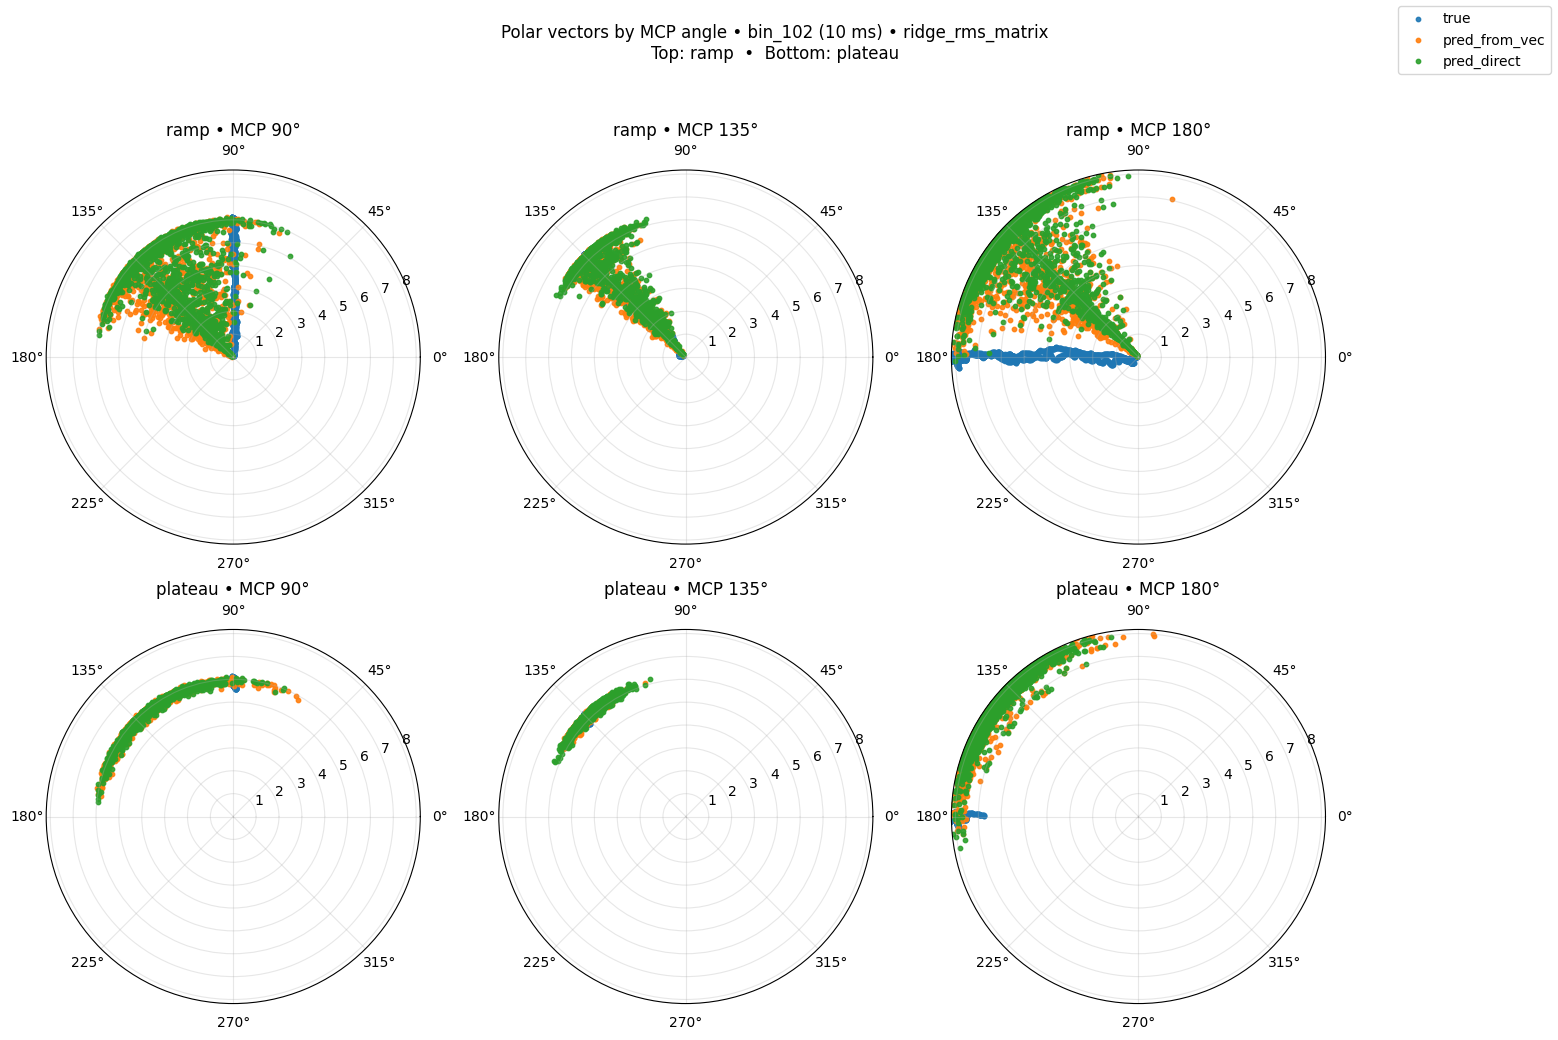


=== bin_len=512 (~50.0 ms) ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=512: X_by_mode keys=['rms_matrix'], y=(9780, 3), groups=22
[DONE] processed files: 11/11
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=512: X_by_mode keys=['rms_matrix'], y=(6434, 3), groups=22
[DONE] processed files: 11/11


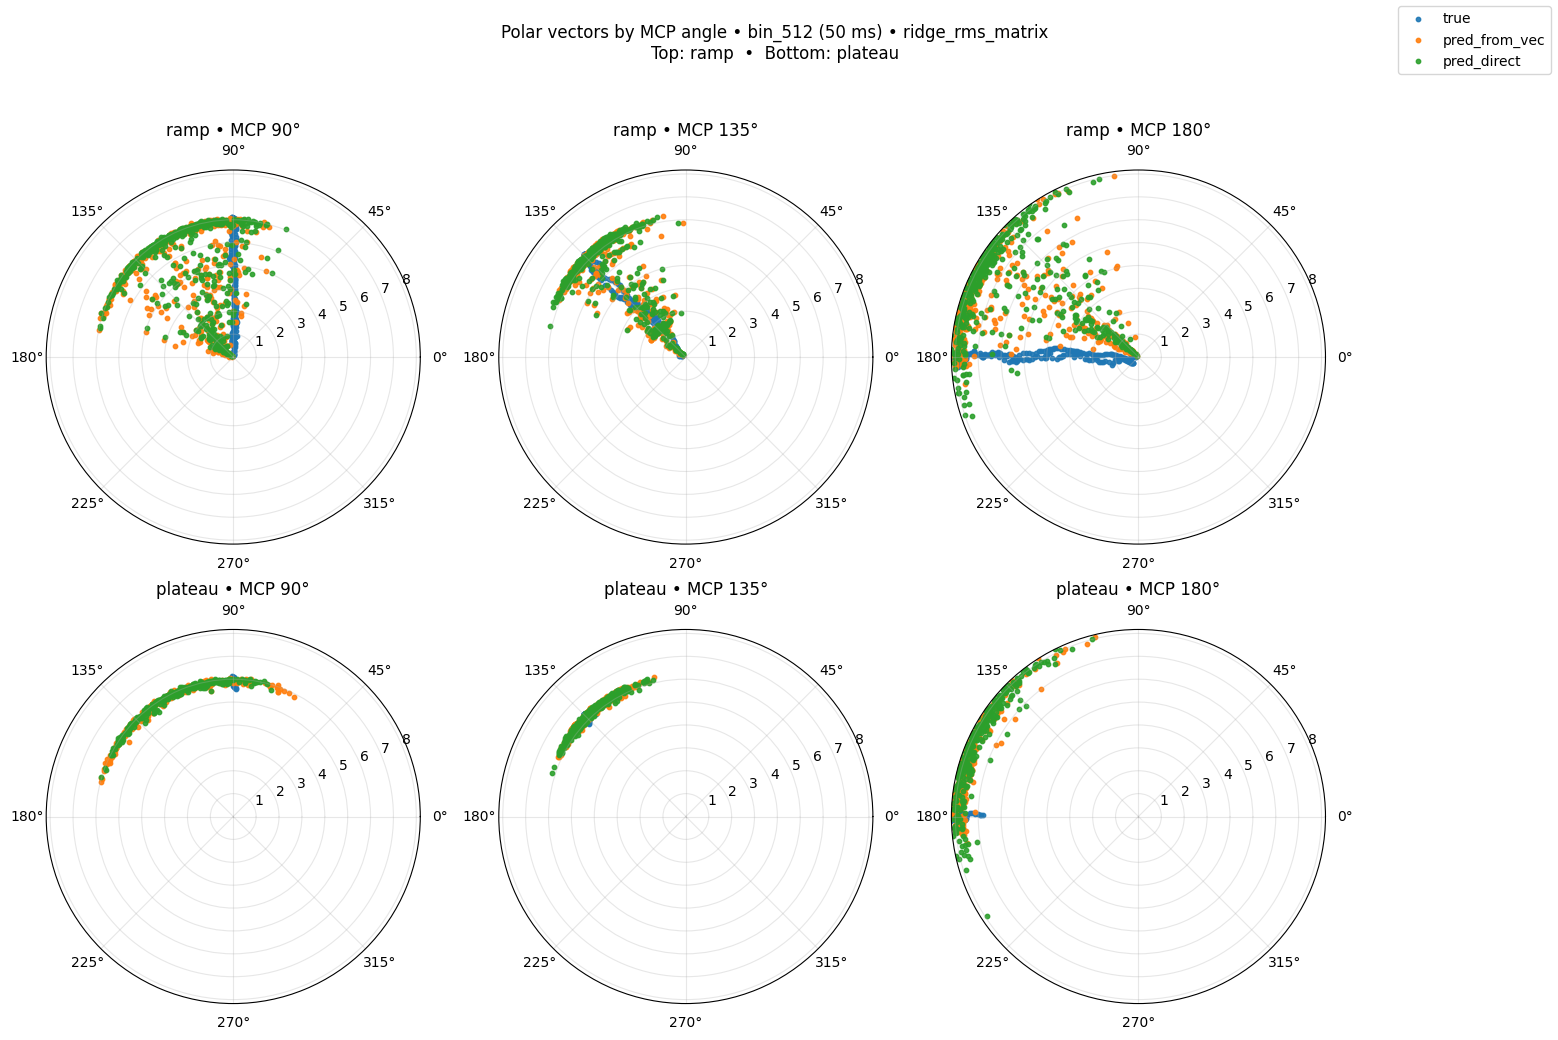


=== bin_len=1024 (~100.0 ms) ===
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=1024: X_by_mode keys=['rms_matrix'], y=(4884, 3), groups=22
[DONE] processed files: 11/11
[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=1024: X_by_mode keys=['rms_matrix'], y=(3211, 3), groups=22
[DONE] processed files: 11/11


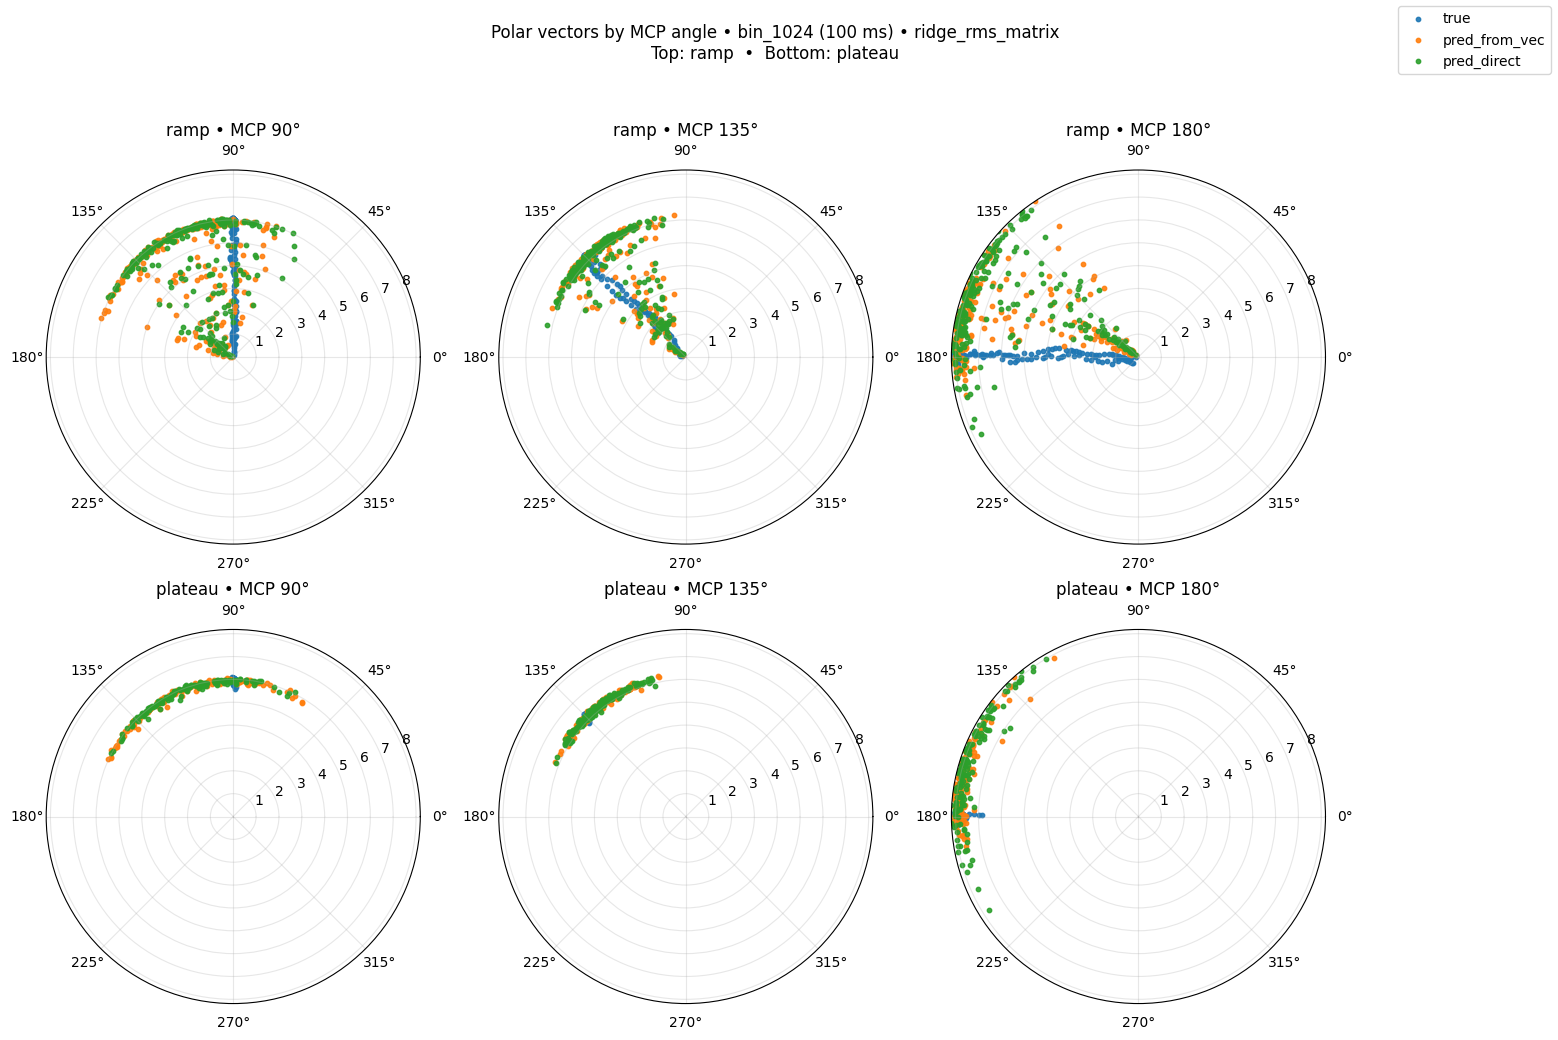

bin_len      bin_ms segment_kind  MCP_deg     n  mae_three_vec_deg  \
0       102    9.960937         ramp     90.0  2517          42.823816   
1       102    9.960937         ramp    135.0  2445           5.726513   
2       102    9.960937         ramp    180.0  2364          37.418608   
3       102    9.960937      plateau     90.0  1469          42.637628   
4       102    9.960937      plateau    135.0  1455           4.953447   
5       102    9.960937      plateau    180.0  1484          32.776206   
6       512   50.000000         ramp     90.0   501          33.706090   
7       512   50.000000         ramp    135.0   487           9.086047   
8       512   50.000000         ramp    180.0   471          25.866263   
9       512   50.000000      plateau     90.0   292          29.866942   
10      512   50.000000      plateau    135.0   289           8.440889   
11      512   50.000000      plateau    180.0   295          18.568867   
12     1024  100.000000         ramp     90.0   250          30.643943   
13     1024  100.000000         ramp    135.0   243          10.901510   
14     1024  100.000000         ramp    180.0   235          20.045107   
15     1024  100.000000      plateau     90.0   146          24.808513   
16     1024  100.000000      plateau    135.0   144          10.305848   
17     1024  100.000000      plateau    180.0   147          13.016969   

    mae_three_direct_deg  
0              38.191861  
1               6.347284  
2              43.547412  
3              38.102761  
4               6.085853  
5              39.772549  
6              30.141857  
7               9.764626  
8              31.863796  
9              28.194878  
10              9.227758  
11             25.354011  
12             27.866446  
13             10.829502  
14             25.859254  
15             23.625574  
16             10.452137  
17             19.769297

In [24]:
# --- USER CONFIG (edit these to your run folders) ---
from pathlib import Path
COMBINED_DIR = Path("data/preprocessing/P3_combined")  # where *_combined.npy live
RESULTS_ROOT_THREE_RAMP = Path("results_feat/P3_ramp")     # 3-target run trained on ramp segments
RESULTS_ROOT_THREE      = Path("results_feat/P3_angle")    # 3-target run trained on plateau/target segments
RMS_WIN = 100
RANDOM_STATE = 42

MODE = "rms_matrix"     # feature mode used in both runs ("rms_matrix" or "all_channels", etc.)
BIN_CHOICE = None       # set a specific bin (e.g., 512/1024) or None to iterate all common bins

# Polar plot / radius options
RADIUS_FOR_ANGLE_ONLY = 6
USE_TRUE_FORCE_RADIUS = True
USE_PRED_FORCE_RADIUS = True
USE_FILENAME_FORCE    = False
F_LABEL_TO_RADIUS = {"F1": 1.0, "F2": 2.0}

# === IMPORTS you already have ===
import re, numpy as np, pandas as pd, joblib, math
import matplotlib.pyplot as plt

from experiments_xy import (
    collect_dataset_from_combined,
    split_one_plateau_per_angle_test,   # MCP-angle split
)

# ---------- helpers (you already have some of these in your notebook) ----------

def _load_bin_dir(root: Path):
    bins = sorted([p for p in root.glob("bin_*") if p.is_dir()])
    return {int(p.name.split("_",1)[1]): p for p in bins}

def _load_model_and_scaler(bin_dir: Path, mode=MODE):
    model_path = bin_dir / f"ridge_{mode}.joblib"
    y_scaler_path = bin_dir / "y_scaler.joblib"
    if not model_path.exists():
        raise FileNotFoundError(f"Missing model: {model_path}")
    model = joblib.load(model_path)
    y_scaler = joblib.load(y_scaler_path) if y_scaler_path.exists() else None
    return model, y_scaler

def angle_from_fx_fy(fx, fy):
    ang = np.degrees(np.arctan2(fy, fx))
    return np.where(ang < 0, ang + 360.0, ang)

def circ_diff_deg(a_deg, b_deg):
    return (a_deg - b_deg + 180.0) % 360.0 - 180.0

def circ_mae_deg(a_deg, b_deg):
    return float(np.mean(np.abs(circ_diff_deg(a_deg, b_deg))))

def _estimate_fs_from_any_file(combined_dir: Path) -> float:
    files = sorted(combined_dir.glob("*_combined.npy"))
    if not files:
        raise FileNotFoundError(f"No *_combined.npy in {combined_dir}")
    payload = np.load(str(files[0]), allow_pickle=True).item()
    t = np.asarray(payload.get("time_s", []), float)
    if t.size >= 2:
        dt = float(np.median(np.diff(t)))
        if dt > 0:
            return 1.0 / dt
    meta = payload.get("meta", {}) or {}
    for key in ("fs_force", "fs_emg"):
        v = meta.get(key, None)
        try:
            if v is not None and np.isfinite(float(v)):
                return float(v)
        except Exception:
            pass
    raise RuntimeError("Could not estimate sampling rate (fs)")

def _force_label_from_path(p: str) -> str | None:
    base = Path(p).stem
    m = re.search(r'_(F\d+)_', base, flags=re.IGNORECASE)
    return m.group(1).upper() if m else None

# === 0) Discover common bins in your two 3-target model roots (ramp vs plateau) ===
bins_ramp   = _load_bin_dir(RESULTS_ROOT_THREE_RAMP)
bins_target = _load_bin_dir(RESULTS_ROOT_THREE)
all_common_bins = sorted(set(bins_ramp.keys()) & set(bins_target.keys()))
if not all_common_bins:
    raise SystemExit("No common bin_* across the ramp and plateau results roots.")

if BIN_CHOICE is not None:
    common_bins = [b for b in all_common_bins if b == BIN_CHOICE]
    if not common_bins:
        raise SystemExit(f"BIN_CHOICE={BIN_CHOICE} not available in both results roots (have {all_common_bins}).")
else:
    common_bins = all_common_bins

print("Common bins to evaluate:", common_bins)

# === 0.5) Estimate fs once to convert bin_len -> bin_sec for dataset building ===
fs_est = _estimate_fs_from_any_file(COMBINED_DIR)
print(f"Estimated fs ≈ {fs_est:.2f} Hz")

# ---------- core evaluator for one segment kind & one bin ----------
def _eval_one_segment_kind(segment_kind: str, bin_len: int, bin_sec: float, model_root: Path):
    """
    Build dataset with given segment_kind, split, load 3-target model for this bin and MODE,
    run predictions, and return a dict with angles/radii + MCP labels to plot/score.
    """
    # Build dataset
    buckets = collect_dataset_from_combined(
        str(COMBINED_DIR),
        bin_sec=bin_sec,
        include_angle_target=True,      # keep Fx,Fy,Angle in y
        rms_win_samples=RMS_WIN,
        modes=(MODE,),
        segment_kind=segment_kind,
    )
    if bin_len not in buckets:
        raise SystemExit(f"[{segment_kind}] Collector returned bins {sorted(buckets.keys())}, not the requested {bin_len}.")

    pack = buckets[bin_len]
    X_by_mode = pack["X_by_mode"]
    if MODE not in X_by_mode:
        raise SystemExit(f"[{segment_kind}] MODE='{MODE}' not in {list(X_by_mode.keys())}")

    X = X_by_mode[MODE]             # (N, C_mode)
    y = pack["y"]                   # (N, 3) -> Fx, Fy, Angle
    groups = pack["groups"]         # (N,)
    nominal_angles_all = pack["nominal_angles"]  # (N,)

    # Split holdout by MCP angle
    train_idx, test_idx, test_groups = split_one_plateau_per_angle_test(groups, nominal_angles_all, rng=RANDOM_STATE)
    X_te, y_te, groups_te = X[test_idx], y[test_idx], groups[test_idx]
    mcp_labels = nominal_angles_all[test_idx]

    # Ground truth
    angle_true = angle_from_fx_fy(y_te[:,0], y_te[:,1])
    r_true_mag = np.hypot(y_te[:,0], y_te[:,1])
    if USE_FILENAME_FORCE:
        src_paths = np.array([g.split("::", 1)[0] for g in groups_te])
        f_labels = np.array([_force_label_from_path(p) for p in src_paths])
        r_true = np.array([F_LABEL_TO_RADIUS.get(lbl, np.nan) for lbl in f_labels], float)
    else:
        r_true = r_true_mag if USE_TRUE_FORCE_RADIUS else np.ones_like(r_true_mag)

    # Load 3-target model for this MODE & bin
    bin_dir = _load_bin_dir(model_root)[bin_len]
    model_t, ysc_t = _load_model_and_scaler(bin_dir, MODE)  # 3-target run

    # Predict
    pred_t_norm = model_t.predict(X_te)
    pred_t = ysc_t.inverse_transform(pred_t_norm) if ysc_t is not None else pred_t_norm

    if pred_t.shape[1] >= 2:
        angle_pred_vec = angle_from_fx_fy(pred_t[:,0], pred_t[:,1])
        r_pred_vec     = np.hypot(pred_t[:,0], pred_t[:,1]) if USE_PRED_FORCE_RADIUS else np.ones(len(pred_t))
    else:
        angle_pred_vec = np.full(len(angle_true), np.nan)
        r_pred_vec     = np.full(len(angle_true), np.nan)

    angle_pred_direct = pred_t[:,2] if pred_t.shape[1] >= 3 else np.full(len(angle_true), np.nan)
    angle_pred_direct = (angle_pred_direct % 360 + 360) % 360

    return dict(
        mcp_labels=mcp_labels,
        angle_true=angle_true,
        r_true=r_true,
        angle_pred_vec=angle_pred_vec,
        r_pred_vec=r_pred_vec,
        angle_pred_direct=angle_pred_direct,
        bin_len=bin_len,
        bin_sec=bin_sec,
        segment_kind=segment_kind,
    )

# ---------- stacked polar plot & summary per bin (ramp vs plateau) ----------
def _plot_stacked_and_summarize(bin_payload_ramp, bin_payload_plateau, mode_label="ridge_"+MODE):
    """
    Stack two rows of polar plots per MCP angle:
      row 0: ramp evaluation
      row 1: plateau evaluation
    Summarize MAE per MCP for each row and return two DataFrames (ramp_df, plateau_df).
    """
    pr = bin_payload_ramp
    pt = bin_payload_plateau

    # union of MCPs present
    mcp_r = np.array([x for x in pr["mcp_labels"] if np.isfinite(x)])
    mcp_t = np.array([x for x in pt["mcp_labels"] if np.isfinite(x)])
    all_mcp = sorted(set(mcp_r.tolist()) | set(mcp_t.tolist()))
    if len(all_mcp) == 0:
        print("[WARN] No finite MCP angles found in either set.")
        return pd.DataFrame(), pd.DataFrame()

    cols = min(4, len(all_mcp))
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(5.2*cols, 5.2*rows),
                             subplot_kw={"projection": "polar"}, squeeze=False)
    # rmax for nice scaling (use true radii from both)
    all_r = []
    all_r.extend(pr["r_true"][~np.isnan(pr["r_true"])])
    all_r.extend(pt["r_true"][~np.isnan(pt["r_true"])])
    rmax = max(1.0, np.nanpercentile(all_r, 99)) if all_r else 1.0

    def _block(ax, mcp_val, payload, title_prefix):
        lbls = payload["mcp_labels"]
        idxs = np.where(np.isclose(lbls, mcp_val, equal_nan=False))[0]
        if idxs.size == 0:
            ax.set_title(f"{title_prefix} • MCP {mcp_val:.0f}° (no data)")
            ax.set_rmax(rmax); ax.grid(True, alpha=0.3)
            return dict(MCP_deg=float(mcp_val), n=0,
                        mae_three_vec_deg=np.nan, mae_three_direct_deg=np.nan)

        ang_true = np.deg2rad(payload["angle_true"][idxs]);   r_t = payload["r_true"][idxs]
        ang_vec  = np.deg2rad(payload["angle_pred_vec"][idxs])
        ang_dir  = np.deg2rad(payload["angle_pred_direct"][idxs])

        # plot
        ax.scatter(ang_true, r_t, s=10, label="true", alpha=0.9)
        ax.scatter(ang_vec,  r_t, s=10, label="pred_from_vec", alpha=0.9)
        ax.scatter(ang_dir,  r_t, s=10, label="pred_direct",   alpha=0.9)
        ax.set_title(f"{title_prefix} • MCP {mcp_val:.0f}°")
        ax.set_rmax(rmax); ax.grid(True, alpha=0.3)

        # MAE in degrees (circular)
        mae_vec = circ_mae_deg(np.rad2deg(ang_vec), np.rad2deg(ang_true)) if np.isfinite(ang_vec).any() else np.nan
        mae_dir = circ_mae_deg(np.rad2deg(ang_dir), np.rad2deg(ang_true)) if np.isfinite(ang_dir).any() else np.nan
        return dict(MCP_deg=float(mcp_val), n=int(idxs.size),
                    mae_three_vec_deg=mae_vec, mae_three_direct_deg=mae_dir)

    rows_ramp, rows_plateau = [], []
    for j, mcp in enumerate(all_mcp):
        ax_top  = axes[0, j % cols]
        ax_bot  = axes[1, j % cols] if cols > 0 else axes[1, 0]
        # ramp (top row)
        rows_ramp.append(_block(ax_top, mcp, pr, "ramp"))
        # plateau/target (bottom row)
        rows_plateau.append(_block(ax_bot, mcp, pt, "plateau"))

        # every 'cols' columns, new figure row is already handled by axes grid

    # shared legend (top-left axes)
    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right")

    bin_len = pr["bin_len"]
    bin_ms  = pr["bin_sec"] * 1000.0
    fig.suptitle(f"Polar vectors by MCP angle • bin_{bin_len} ({bin_ms:.0f} ms) • {mode_label}\nTop: ramp  •  Bottom: plateau", y=0.98)
    fig.tight_layout(rect=[0,0,0.88,0.95])
    plt.show()

    # Build DataFrames with segment_kind label
    ramp_df = pd.DataFrame(rows_ramp)
    ramp_df.insert(0, "segment_kind", "ramp")
    ramp_df.insert(0, "bin_len", int(bin_len))
    ramp_df.insert(1, "bin_ms", bin_ms)

    tgt_df = pd.DataFrame(rows_plateau)
    tgt_df.insert(0, "segment_kind", "plateau")
    tgt_df.insert(0, "bin_len", int(bin_len))
    tgt_df.insert(1, "bin_ms", bin_ms)

    return ramp_df, tgt_df

# ==============================================================
# === Iterate through bins: build both datasets, predict, stack plots
# ==============================================================

all_summaries = []

print("Evaluating MODE:", MODE)
for bin_len in common_bins:
    bin_sec = float(bin_len) / fs_est
    print(f"\n=== bin_len={bin_len} (~{bin_sec*1000:.1f} ms) ===")

    # Evaluate ramp on ramp data
    payload_ramp   = _eval_one_segment_kind("ramp",    bin_len, bin_sec, RESULTS_ROOT_THREE_RAMP)
    # Evaluate target (plateau) on target data
    payload_target = _eval_one_segment_kind("plateau", bin_len, bin_sec, RESULTS_ROOT_THREE)

    # Stacked plot & summaries
    ramp_df, tgt_df = _plot_stacked_and_summarize(payload_ramp, payload_target, mode_label=f"ridge_{MODE}")
    if not ramp_df.empty:
        all_summaries.append(ramp_df)
    if not tgt_df.empty:
        all_summaries.append(tgt_df)

# Final combined summary (one row per MCP per bin, per segment_kind)
summary_df = pd.concat(all_summaries, ignore_index=True) if all_summaries else pd.DataFrame()
summary_df


In [25]:
# 1️⃣ Overall mean MAE across modes
overall_mean = summary_df.groupby("segment_kind")[["mae_three_vec_deg","mae_three_direct_deg"]].mean()
print("\n=== Mean MAE (°) per mode ===")
print(overall_mean.round(2))
best_overall = overall_mean.mean(axis=1).idxmin()
print(f"\nBest mode overall: {best_overall}")

# 2️⃣ Mean per MCP (across all modes)
mean_per_mcp = summary_df.groupby("MCP_deg")[["mae_three_vec_deg","mae_three_direct_deg"]].mean()
print("\n=== Mean MAE (°) per MCP angle ===")
print(mean_per_mcp.round(2))


=== Mean MAE (°) per mode ===
              mae_three_vec_deg  mae_three_direct_deg
segment_kind                                         
plateau                   20.60                 22.29
ramp                      24.02                 24.93

Best mode overall: plateau

=== Mean MAE (°) per MCP angle ===
         mae_three_vec_deg  mae_three_direct_deg
MCP_deg                                         
90.0                 34.08                 31.02
135.0                 8.24                  8.78
180.0                24.62                 31.03
